# Method Comparison

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/method_comparison_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Copy Score Files

In [ ]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./

## Read in Score Files

In [3]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')
# motif_summedScore_frame = motif_summedScore_frame.ix[:,3:]

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [4]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_summedScore_frame = motif_summedScore_frame[motif_summedScore_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [5]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Grid Search

C : float, optional (default=1.0)

Inverse of regularization strength; must be a positive float. 

Like in support vector machines, smaller values specify stronger regularization.


In [140]:
numIterations = 5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac','p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

In [ ]:
### for all peaks in vehicle for all motifs
C_vals = []
factorPair_vals = []
aucs = []

for c in [10**x for x in range(-4,4)]:
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
                 summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals.append(c)
        factorPair_vals.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs.append(mean_roc_auc)



In [158]:
c_range = [10**x for x in range(-4,4)]
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))
for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals[i]
    auc_val = aucs[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

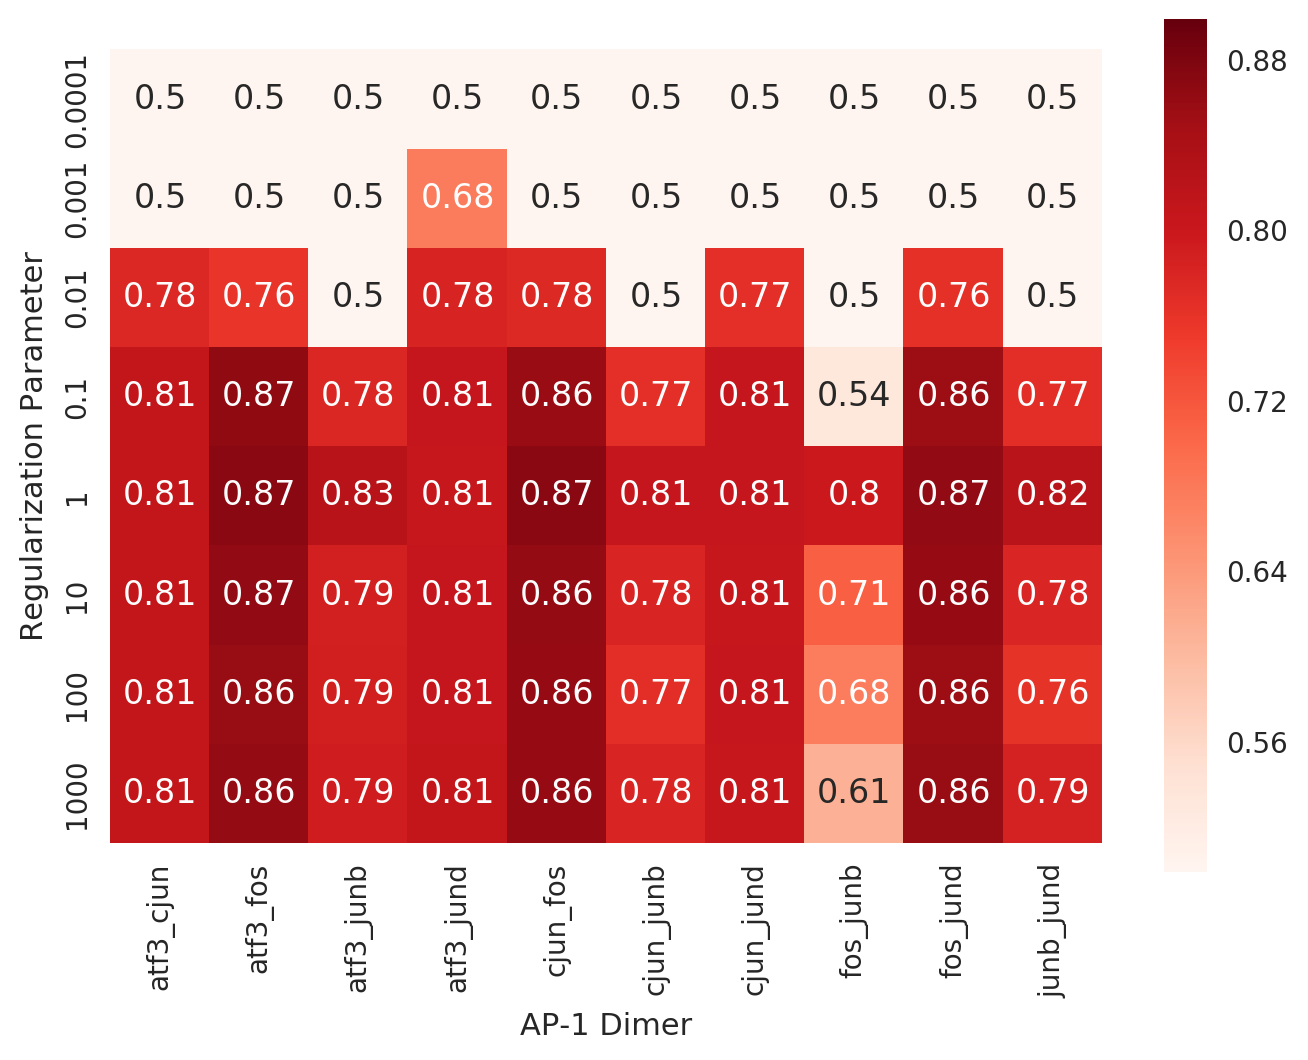

In [165]:
sns.heatmap(c_frame.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.2g',
           vmin=0.5,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

In [ ]:
### for all peaks in vehicle for all motifs
C_vals_ones = []
factorPair_vals_ones = []
aucs_ones = []

for c in range(1,10):
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
                 summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs_ones = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs_ones.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs_ones) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals_ones.append(c)
        factorPair_vals_ones.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs_ones.append(mean_roc_auc)




In [170]:
c_range = [x for x in range(1,10)]
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))

for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals_ones[i]
    auc_val = aucs_ones[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame_ones = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

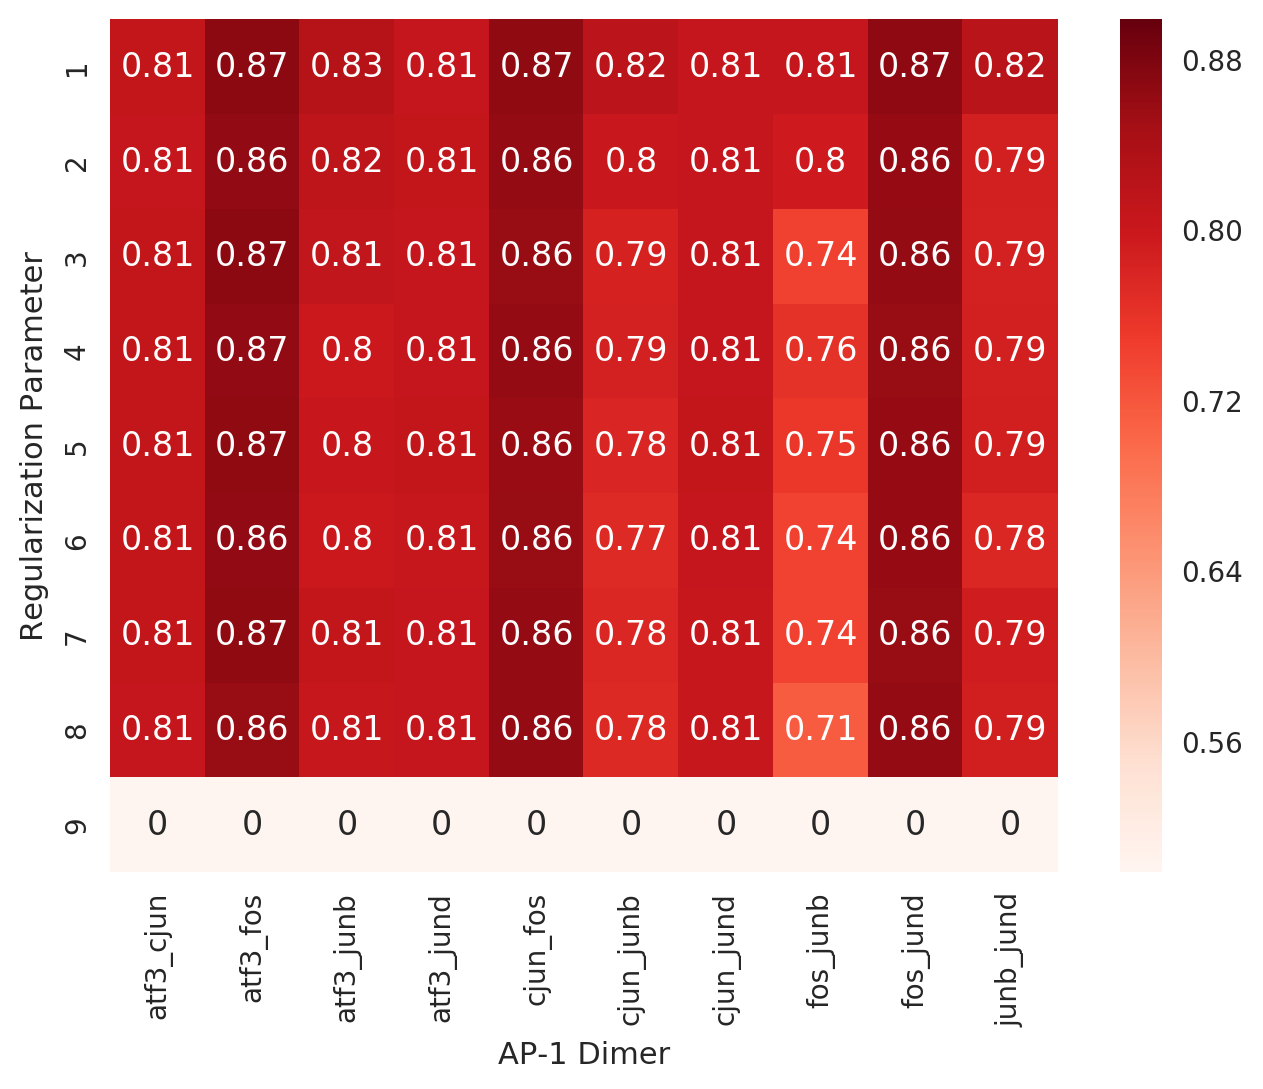

In [171]:
sns.heatmap(c_frame_ones.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.2g',
           vmin=0.5,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

In [ ]:
### for all peaks in vehicle for all motifs
C_vals_tenths = []
factorPair_vals_tenths = []
aucs_tenths = []

for c in np.arange(0.1,1,0.1):
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs_tenths = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs_tenths.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs_tenths) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals_tenths.append(c)
        factorPair_vals_tenths.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs_tenths.append(mean_roc_auc)






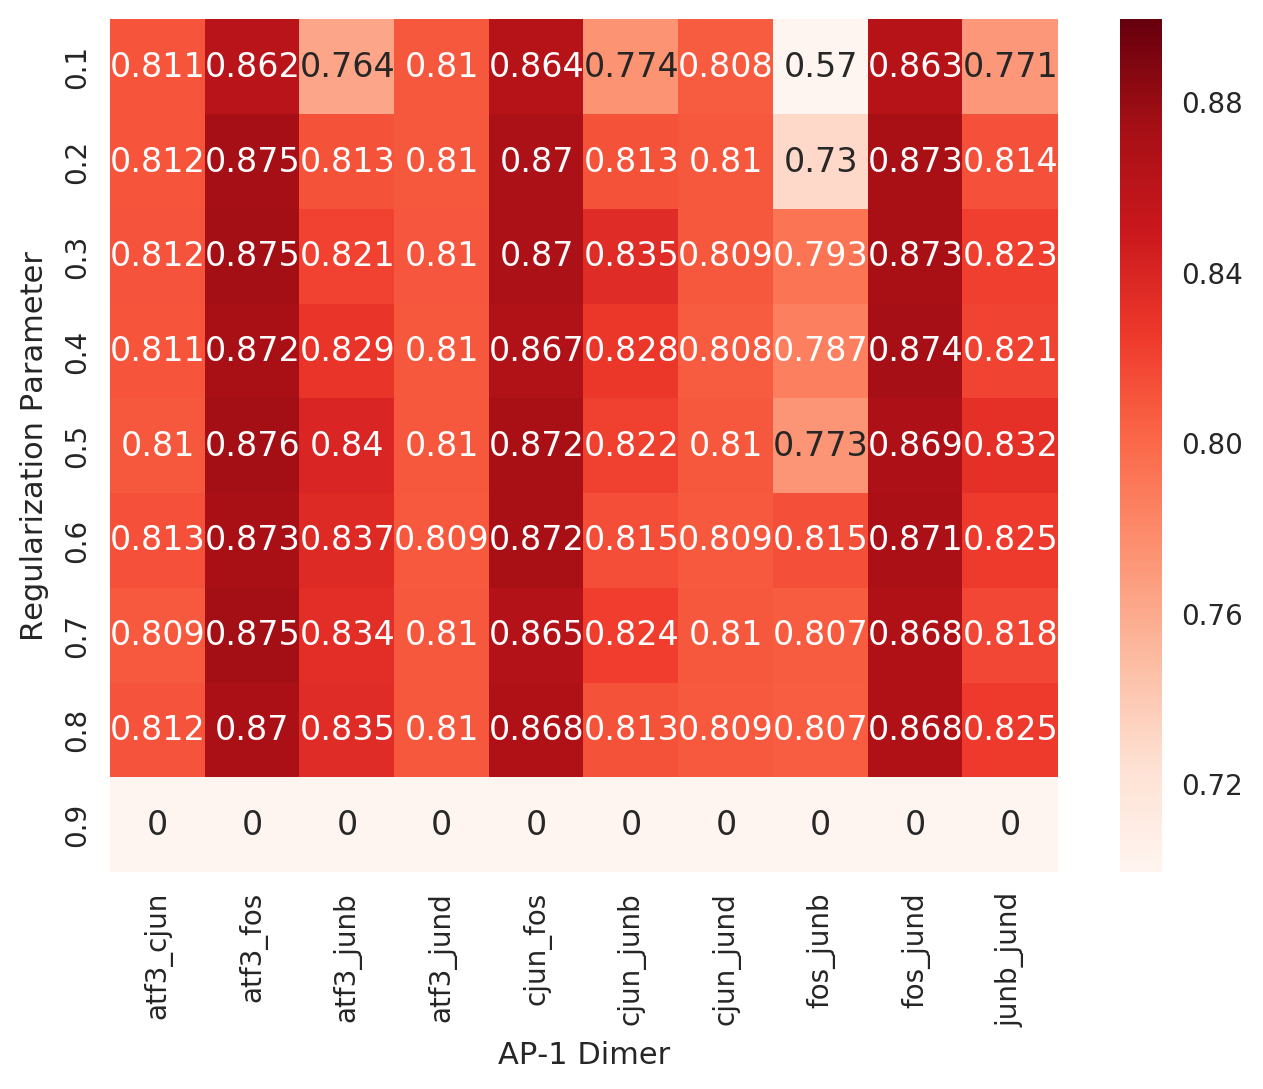

In [176]:
c_range = np.arange(0.1,1,0.1)
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))

for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals_tenths[i]
    auc_val = aucs_tenths[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame_tenths = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

sns.heatmap(c_frame_tenths.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.3g',
           vmin=0.7,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

## Z-Score Normalization (standardization) and Motif Selection Experiments

In [647]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [648]:
# standardize motif scores
scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

In [649]:
### for all peaks in vehicle for all motifs
numIterations = 5
factor_coeff_dict = {}
factor_auc_dict_veh = {}
factor_prob_dict_veh = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  


for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_probs = None
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])\

            current_roc_auc = auc(fpr, tpr)
            all_aucs.append(current_roc_auc)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict['_'.join(factorPair).replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh['_'.join(factorPair).replace('c57bl6_','')] = all_probs
        print(factorPair, mean_roc_auc)
coefficients_frame_veh_std = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_std.index = standardized_motif_frame.columns.values
probs_frame_veh = pd.DataFrame(factor_prob_dict_veh,
                              index = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)].index.values)



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


('c57bl6_atf3', 'c57bl6_cjun') 0.811174822678
('c57bl6_atf3', 'c57bl6_fos') 0.860307972809
('c57bl6_atf3', 'c57bl6_junb') 0.795845554886
('c57bl6_atf3', 'c57bl6_jund') 0.807917053129
('c57bl6_cjun', 'c57bl6_fos') 0.863626831553
('c57bl6_cjun', 'c57bl6_junb') 0.788052188838
('c57bl6_cjun', 'c57bl6_jund') 0.80725888725
('c57bl6_fos', 'c57bl6_jund') 0.85605969783
('c57bl6_junb', 'c57bl6_jund') 0.778600796684


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


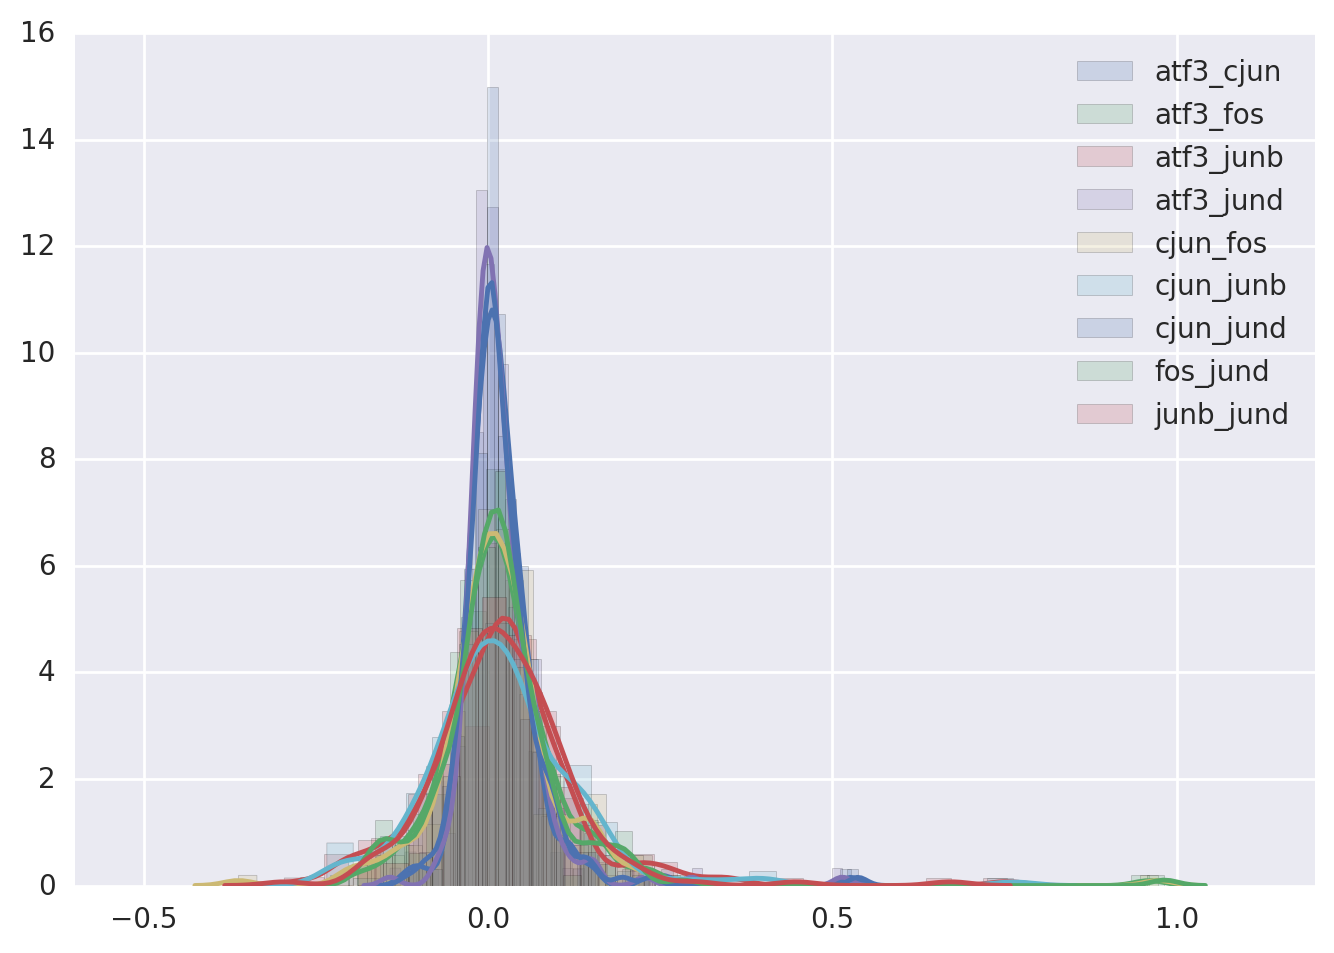

In [656]:
for col in coefficients_frame_veh_std.columns.values:
    sns.distplot(coefficients_frame_veh_std[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

In [651]:
# t-test on distributions of weights
# demonstrate that the distributions are have similar distributions
p_threshold = 0.05
dimers = coefficients_frame_veh_std.columns.values
for i in range(len(dimers) - 1):
    d1 = dimers[i]
    for j in range(i + 1, len(dimers)):
        d2 = dimers[j]
        d1_weights = coefficients_frame_veh_std[d1]
        d2_weights = coefficients_frame_veh_std[d2]
        stat, pval_ttest = scipy.stats.ttest_ind(d1_weights, d2_weights)
        stat, pval_bartlett = scipy.stats.bartlett(d1_weights, d2_weights)
        if pval_ttest < p_threshold or pval_bartlett < p_threshold:
            print(d1, d2, pval_ttest, pval_bartlett)
        else:
            print(d1, d2, 'have similar distributions')

atf3_cjun atf3_fos 0.941521644525 2.28846804023e-12
atf3_cjun atf3_junb 0.973592877487 1.86697322776e-17
atf3_cjun atf3_jund have similar distributions
atf3_cjun cjun_fos 0.755176221421 1.09808988902e-14
atf3_cjun cjun_junb 0.908476117364 2.29046735662e-18
atf3_cjun cjun_jund have similar distributions
atf3_cjun fos_jund 0.895341667348 8.49657496515e-14
atf3_cjun junb_jund 0.680531042229 6.28109115729e-13
atf3_fos atf3_junb have similar distributions
atf3_fos atf3_jund 0.989256676536 1.63462614747e-12
atf3_fos cjun_fos have similar distributions
atf3_fos cjun_junb have similar distributions
atf3_fos cjun_jund 0.910412255953 5.69114509535e-12
atf3_fos fos_jund have similar distributions
atf3_fos junb_jund have similar distributions
atf3_junb atf3_jund 0.910221445909 1.25923596248e-17
atf3_junb cjun_fos have similar distributions
atf3_junb cjun_junb have similar distributions
atf3_junb cjun_jund 0.99756313681 5.4373792263e-17
atf3_junb fos_jund have similar distributions
atf3_junb junb_j

In [652]:
# transform_coffcients into z-scores
coefficients_zscore_frame_veh_std = coefficients_frame_veh_std[[]]
for col in coefficients_frame_veh_std:
    coefficients_zscore_frame_veh_std[col] = scipy.stats.mstats.zscore(coefficients_frame_veh_std[col].values)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [653]:
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame_veh_std = pd.DataFrame(scaler.fit_transform(coefficients_frame_veh_std))
coefficients_standardized_frame_veh_std.index = coefficients_frame_veh_std.index.values
coefficients_standardized_frame_veh_std.columns = coefficients_frame_veh_std.columns.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


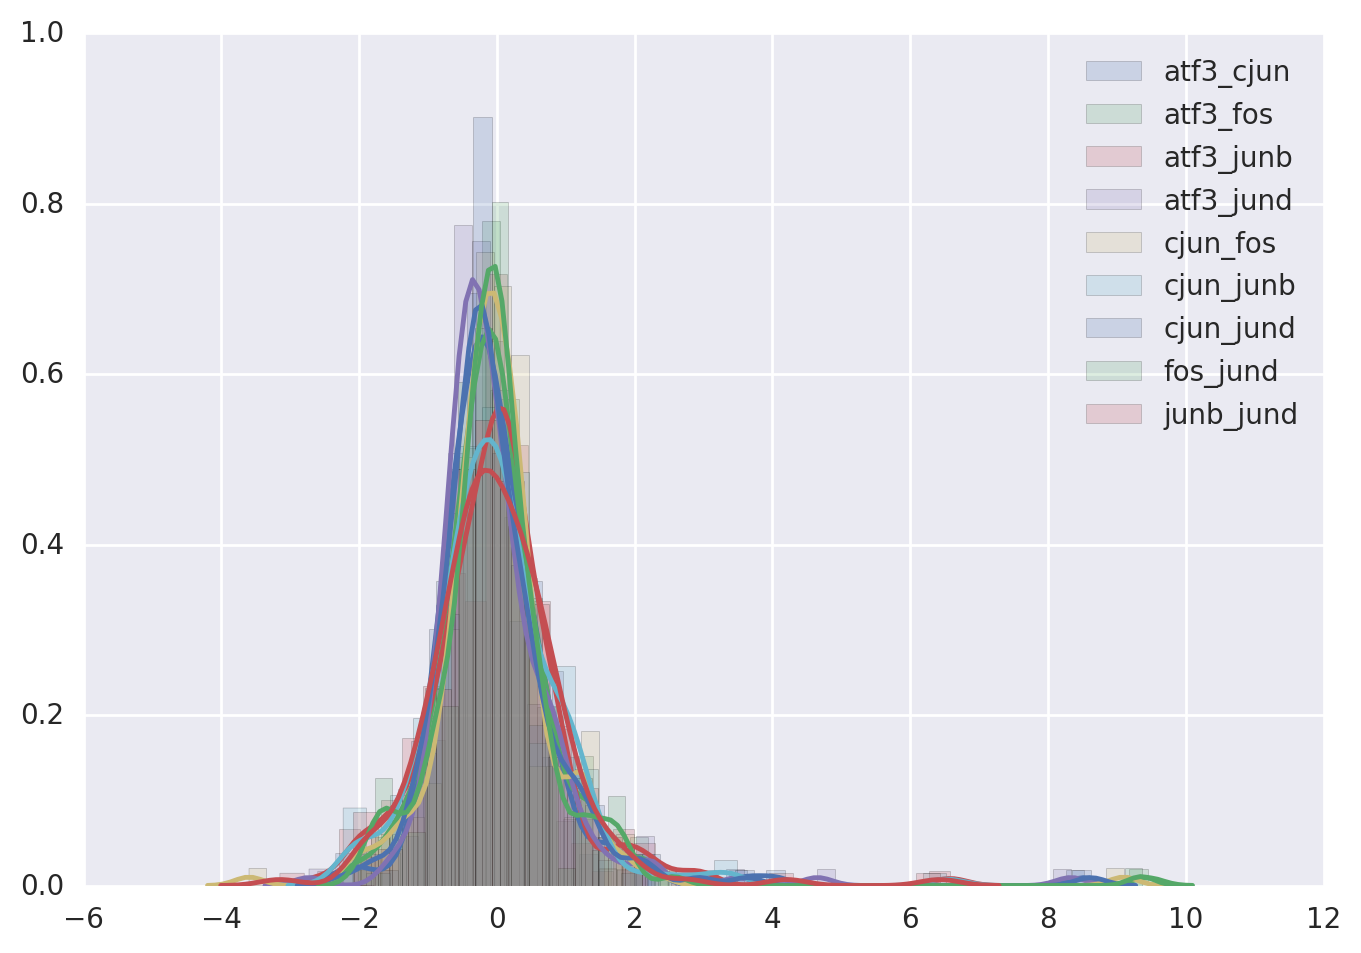

In [739]:
for col in coefficients_standardized_frame_veh_std.columns.values:
    if not '*' in col:
        sns.distplot(coefficients_standardized_frame_veh_std[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

In [ ]:
### plot coefficents for vehicle
weight_threshold = 1.5
# data = coefficients_zscore_frame_veh_std
data = coefficients_standardized_frame_veh_std

data = data[(data.max(axis=1) >= weight_threshold) |
            (data.min(axis=1) < -1 * weight_threshold)
            ][[x for x in data.columns if not '_' in x]]

cg = sns.clustermap(data,
                   vmax=1.5*weight_threshold,
                   vmin=-1.5*weight_threshold,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
#                     square=True,
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );



## Weighting Samples

In [74]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [75]:
### for all peaks in vehicle for all motifs
numIterations = 5

factor_auc_dict_unweighted = {}
treatment = 'veh'
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  

for factor in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + factor + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        all_coefficients = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l2',
                                                                    max_iter=200,
                                                                    solver='sag',
                                                                    n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_unweighted[factor.replace('c57bl6_','')]= mean_roc_auc

atf3 0.836554436298 0.710953214166
cjun 0.811937742741 0.469931672796
fos 0.859883514146 0.354028078201
junb 0.690343938168 0.0225118529586
jund 0.808235044782 0.565632027578


In [79]:
### for all peaks in vehicle for all motifs with weighted samples
numIterations = 5

factor_auc_dict_weighted = {}
treatment = 'veh'
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
current_summary_frame = summary_frame[summary_frame.index.isin(c57bl6_indices)]
current_feature_frame = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
for factor in ap1_members:
    features = current_feature_frame
    labels = current_summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')

    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            peak_scores = current_summary_frame[current_summary_frame.index.isin(training_labels.index.values)]['c57bl6_' + factor + '_veh'].values
            max_score = np.max(peak_scores)
            normalized_peak_scores = peak_scores
            
            normalized_peak_scores = np.array([np.sqrt(x) if x > 0 else 1 for x in normalized_peak_scores])
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l2', 
                                                                    n_jobs=-1,
                                                                    max_iter=200,
                                                                    solver='sag')

            lr_classifier.fit(training_features, 
                              training_labels,
                             sample_weight=normalized_peak_scores)

            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_weighted[factor.replace('c57bl6_','')]= mean_roc_auc

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


atf3 0.83918292459 0.711850460796
cjun 0.813704096086 0.467475742038
fos 0.859543413936 0.338023939776
junb 0.673089814643 0.0205612531945
jund 0.807961370619 0.558555506916


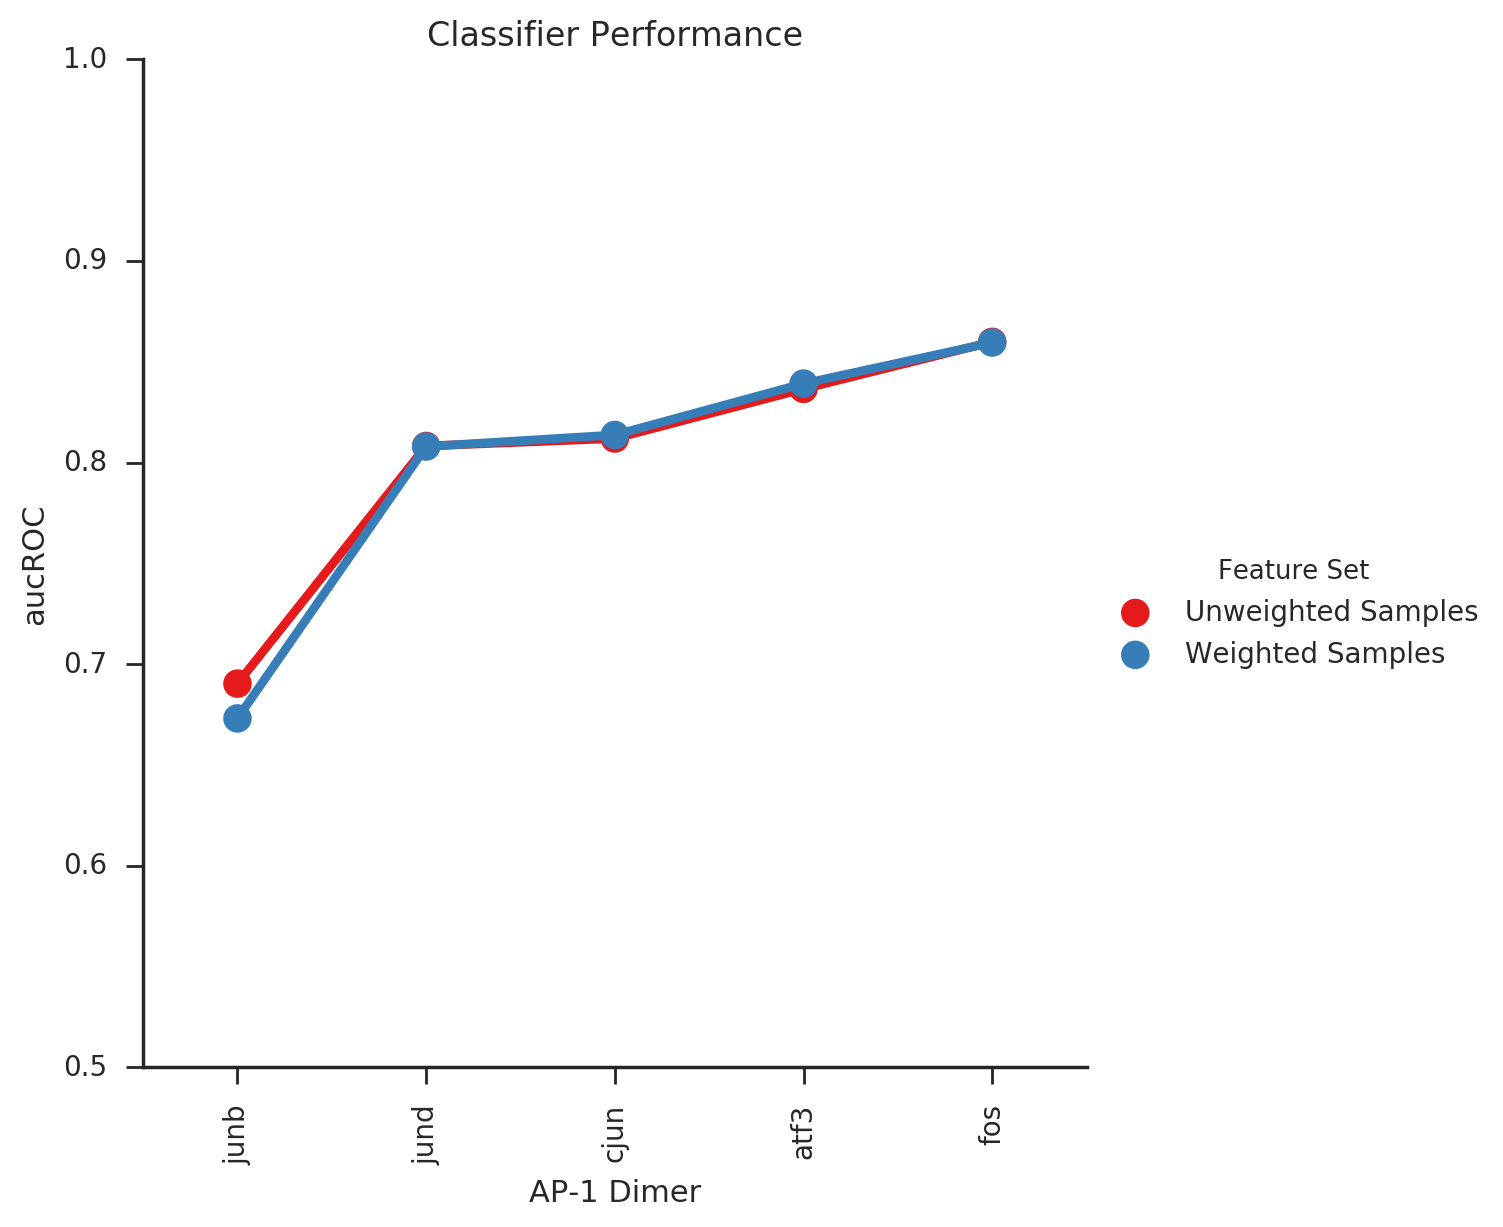

In [80]:
factor_list = []
aucs = []
feature_list = []
for factor in sorted(factor_auc_dict_unweighted.keys()):
    factor_list = factor_list + 2 * [factor]
    feature_list = feature_list + [ 'Unweighted Samples', 'Weighted Samples']
    aucs.append(factor_auc_dict_unweighted[factor])
    aucs.append(factor_auc_dict_weighted[factor])
   


data = pd.DataFrame({'Factor':factor_list,
                     'AUC':aucs,
                     'Feature Set':feature_list})

# sort factors according to ascending AUC with all motifs
factor_auc_tuples = tuple(zip(data[data['Feature Set']=='Unweighted Samples']['Factor'], 
                              data[data['Feature Set']=='Unweighted Samples']['AUC']))

sorted_factors = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]

with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = data,
                                x='Factor',
                                y='AUC',
                                order = sorted_factors,
                                hue='Feature Set',
                                palette='Set1',
                                size=6)

    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance')
    

## AdaBoost

In [306]:
### for all peaks in vehicle for all motifs
numIterations = 1

factor_auc_dict_adaboost = {}

for factor in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = current_summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier

#             adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
#                                     base_estimator = sklearn.tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
#                                     max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
#                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
#                                     presort=False, random_state=None, splitter='best')
#                                                                      )
#             adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
#                                     base_estimator = sklearn.linear_model.LogisticRegression(penalty='l2', 
#                                                                                             n_jobs=-1,
#                                                                                             max_iter=200,
#                                                                                             solver='sag')
#                                                                      )
            adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100) 
            adaboost_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas = adaboost_classifier.predict_proba(test_features)
            
            # retrieve predictions for each classifier
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, probas[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = adaboost_classifier.predict_proba(features)[:, 1]

#             current_coefficients = adaboost_classifier.coef_.flatten()
#             all_coeficients.append(current_coefficients)


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_adaboost[factor.replace('c57bl6_','')]= mean_roc_auc

atf3 0.795656069855 0.512936035422
cjun 0.773712590269 0.321027786025
fos 0.846352638464 0.279364877681
junb 0.666386254948 0.0148902054031
jund 0.784787538889 0.433562144431


## Label vs Prediction Comparison 

In [477]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [ ]:
### for all dimers in vehicle for all motifs
numIterations = 1
factor_coeff_dict = {}
factor_auc_dict_veh = {}
factor_prob_dict_veh = {}
factor_classifier_dict_veh = {}
for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_precisions = []
        all_probs = None
        
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)
            
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            man_score = np.sum(current_coefficients * test_features.ix[0,:]) + lr_classifier.intercept_
            classifier_score = lr_classifier.decision_function(test_features.ix[0,:])
            print(monomer, man_score, classifier_score, test_labels[0])
            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict['_'.join(factorPair).replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh['_'.join(factorPair).replace('c57bl6_','')] = all_probs
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision, 
              'numTestPositives:', np.sum(test_labels)
             )

In [485]:
# for monomers
for monomer in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_probs = None
        all_precisions = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh[monomer.replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict[monomer.replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh[monomer.replace('c57bl6_','')] = all_probs
        print(monomer.replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision, 
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3 roc: 0.80383217262 precision: 0.530506701891 numTestPositives: 10975
cjun roc: 0.792093639868 precision: 0.501161902958 numTestPositives: 10492
fos roc: 0.825401767027 precision: 0.319753090717 numTestPositives: 2011
junb roc: 0.757304392728 precision: 0.0656161147203 numTestPositives: 976
jund roc: 0.803987829072 precision: 0.631666593392 numTestPositives: 14870


In [511]:
coefficients_frame_veh_std = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_std.index = standardized_motif_frame.columns.values
probs_frame_veh_std = pd.DataFrame(factor_prob_dict_veh,
index = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)].index.values)



In [551]:
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame_veh_std = pd.DataFrame(scaler.fit_transform(coefficients_frame_veh_std))
coefficients_standardized_frame_veh_std.index = coefficients_frame_veh_std.index.values
coefficients_standardized_frame_veh_std.columns = coefficients_frame_veh_std.columns.values

In [ ]:
prob_threshold = 0.1
strain = 'c57bl6'
treatment = 'veh'
for dimer in probs_frame_veh_std.columns.values:
    # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
    #                       4) True Negative, 3) False Positive, 4) False
    
    # determine monomers
    tokens = dimer.split('_')
    m1 = tokens[0]
    m2 = tokens[1]
    
    true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m1 + '_' + treatment) & \
                  summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m2 + '_' + treatment)
    
    probs = probs_frame_veh_std[dimer]
#     prob_ranks = pd.Series(scipy.stats.rankdata(probs), index = probs_frame_veh.index.values)
#     prob_ranks = prob_ranks / np.max(prob_ranks)
    
    predicted_labels = probs_frame_veh_std[dimer] > prob_threshold
#     predicted_labels = prob_ranks > prob_threshold
    
    index_labels_tuples = list(zip(true_labels.index.values, # index
                                   true_labels.values,       # true label
                                   predicted_labels.values)) # predicted label
    TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
    FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
    T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])
    
    TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
    FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
    F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
    
    # visualize peak scores
    if min([len(TP_indices), len(FN_indices), len(T_indices),
            len(TN_indices), len(FP_indices), len(F_indices)]) >0:
        m1_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m1 + '_' + treatment].values

        m2_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m2 + '_' + treatment].values
    
        scores = np.concatenate([m1_TP_scores, m1_FN_scores, m1_T_scores, m1_TN_scores, m1_FP_scores, m1_F_scores,
                                 m2_TP_scores, m2_FN_scores, m2_T_scores, m2_TN_scores, m2_FP_scores, m2_F_scores])
        numIndices = np.sum([len(TP_indices), len(FN_indices), len(T_indices),
                             len(TN_indices), len(FP_indices), len(F_indices)])
        monomers = ([m1] * numIndices )+ ([m2] * numIndices)
        conditions = np.concatenate([len(m1_TP_scores) * ['TP'], 
                                     len(m1_FN_scores) * ['FN'],
                                     len(m1_T_scores) * ['T'], 
                                     len(m1_TN_scores) * ['TN'], 
                                     len(m1_FP_scores) * ['FP'], 
                                     len(m1_F_scores) * ['F'],
                                     len(m2_TP_scores) * ['TP'], 
                                     len(m2_FN_scores) * ['FN'], 
                                     len(m2_T_scores) * ['T'], 
                                     len(m2_TN_scores) * ['TN'], 
                                     len(m2_FP_scores) * ['FP'], 
                                     len(m2_F_scores) * ['F']])
        print(dimer, 'FP', len(FP_indices), 'FN', len(FN_indices), 'TP', len(TP_indices))
        fpr = len(FP_indices)/len(F_indices)
        tpr = len(TP_indices)/len(T_indices)
        
        fnr = len(FN_indices)/len(F_indices)
        tnr = len(TN_indices)/len(F_indices)
        print(dimer, 'LR+',str(tpr/fpr), 'LR-',str(fnr/tnr), 'TPR', tpr, 'FNR', fnr)
        data = pd.DataFrame({'Peak Score': np.log2(scores+1), 'Monomer':monomers, 'Condition':conditions})
        sns.factorplot(data = data, kind='box', y='Peak Score', x = 'Condition', hue = 'Monomer')
        plt.title(dimer + ' '+ str(np.sum(true_labels)))
        plt.show()
        
        sns.distplot(probs_frame_veh[dimer])
        plt.title(dimer)
        plt.show()


atf3 FP 5018 FN 14856 TP 7172
junb_jund LR+ 4.468334949330404 LR- 0.2326739651364939 TPR 0.32558561830397675 FNR 0.2157201562431934
7172 14856 22028 63849 5018 68867


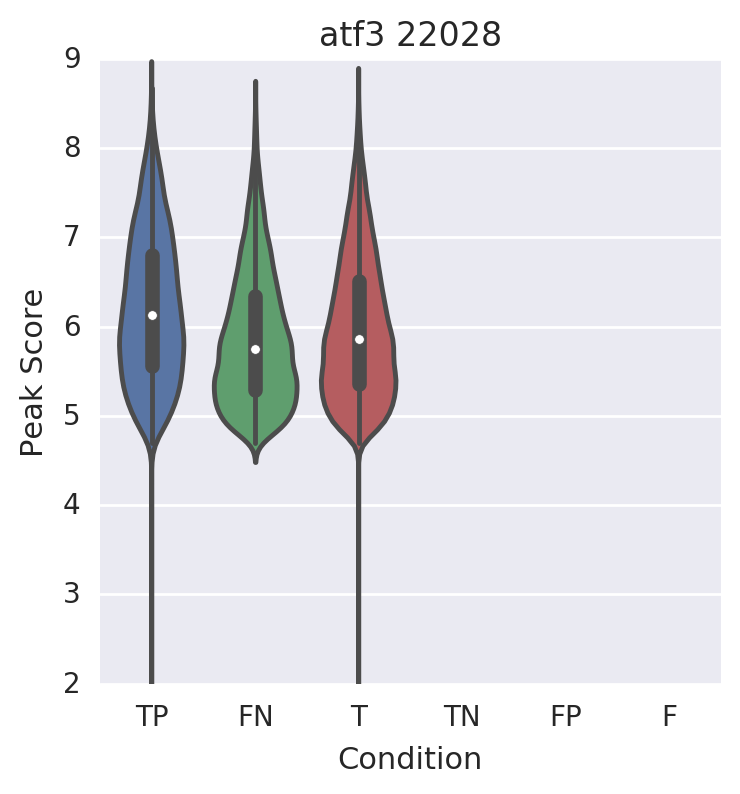

cjun FP 4260 FN 15195 TP 5926
junb_jund LR+ 4.595483301780285 LR- 0.2319351588973349 TPR 0.2805738364660764 FNR 0.21777452919425574
5926 15195 21121 65514 4260 69774


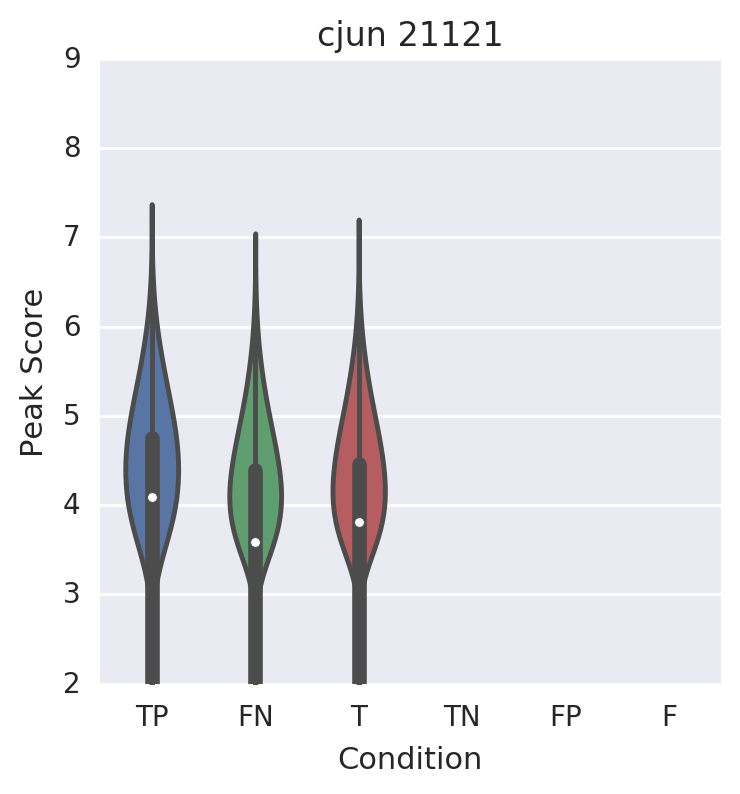

fos FP 658 FN 3536 TP 492
junb_jund LR+ 16.125179971204606 LR- 0.04101659919497964 TPR 0.1221449851042701 FNR 0.04070590673097954
492 3536 4028 86209 658 86867


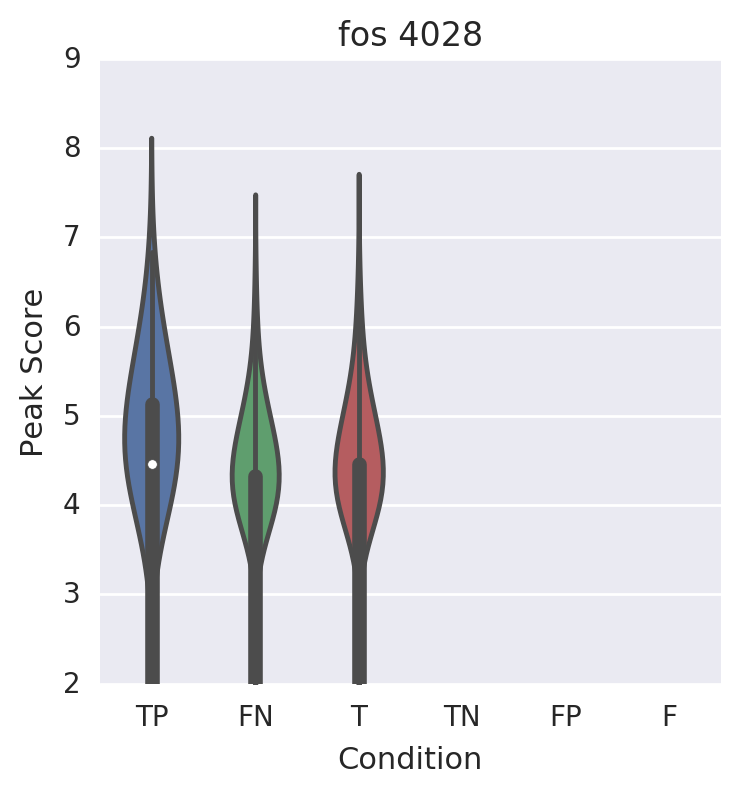

junb FP 1 FN 1963 TP 1
junb_jund LR+ 45.280549898167 LR- 0.022073540987293375 TPR 0.0005091649694501018 FNR 0.022073292777546636
1 1963 1964 88930 1 88931


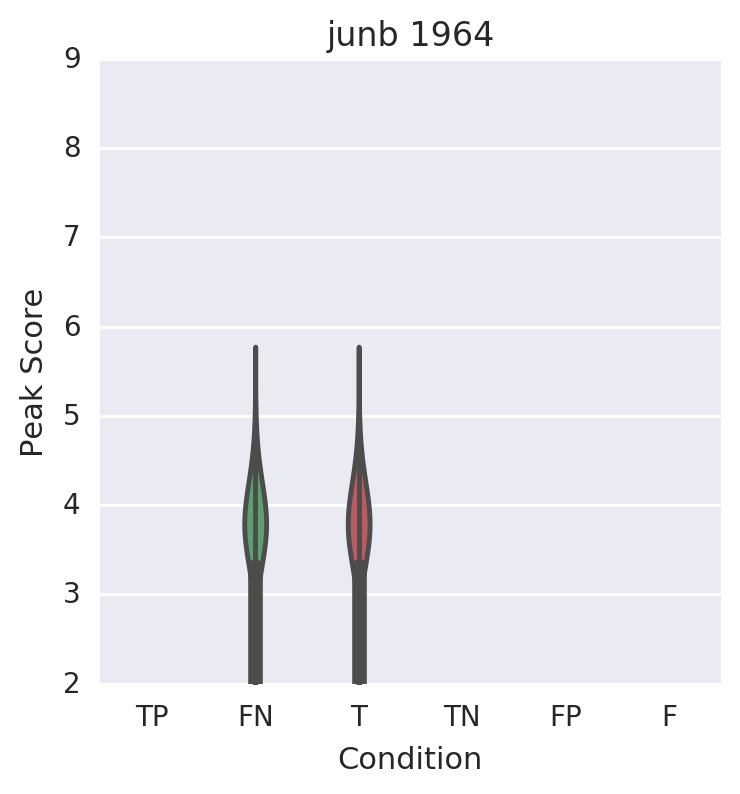

jund FP 7639 FN 15403 TP 14414
junb_jund LR+ 3.8651724026400904 LR- 0.2882351840416176 TPR 0.4834155012241339 FNR 0.25218572972264974
14414 15403 29817 53439 7639 61078


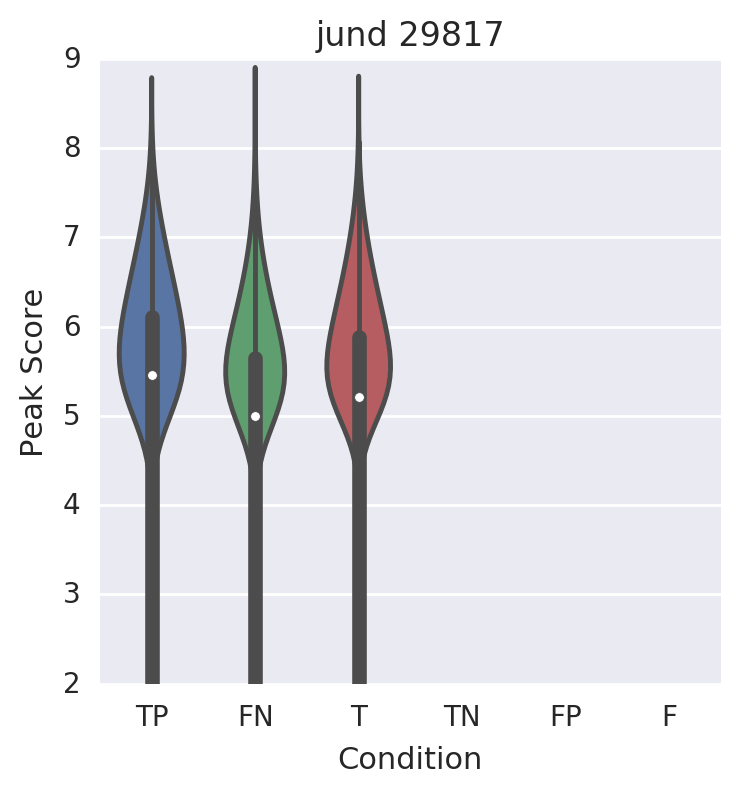

In [549]:
prob_threshold = 0.5
strain = 'c57bl6'
treatment = 'veh'
for monomer in ap1_members:
    # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
    #                       4) True Negative, 3) False Positive, 4) False
    
    # determine monomers
    m1 = monomer
    
    true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m1 + '_' + treatment)
    
    probs = probs_frame_veh_std[m1]

    
    predicted_labels = probs_frame_veh_std[m1] > prob_threshold
    
    index_labels_tuples = list(zip(true_labels.index.values, # index
                                   true_labels.values,       # true label
                                   predicted_labels.values)) # predicted label
    TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
    FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
    T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])
    
    TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
    FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
    F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
    
    # visualize peak scores
    if min([len(TP_indices), len(FN_indices), len(T_indices),
            len(TN_indices), len(FP_indices), len(F_indices)]) >0:
        m1_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m1 + '_' + treatment].values

        scores = np.concatenate([m1_TP_scores, m1_FN_scores, m1_T_scores, m1_TN_scores, m1_FP_scores, m1_F_scores,
                                 ])
        numIndices = np.sum([len(TP_indices), len(FN_indices), len(T_indices),
                             len(TN_indices), len(FP_indices), len(F_indices)])
        monomers = ([m1] * numIndices )
        conditions = np.concatenate([len(m1_TP_scores) * ['TP'], 
                                     len(m1_FN_scores) * ['FN'],
                                     len(m1_T_scores) * ['T'], 
                                     len(m1_TN_scores) * ['TN'], 
                                     len(m1_FP_scores) * ['FP'], 
                                     len(m1_F_scores) * ['F'],
                                     ])
        print(monomer, 'FP', len(FP_indices), 'FN', len(FN_indices), 'TP', len(TP_indices))
        fpr = len(FP_indices)/len(F_indices)
        tpr = len(TP_indices)/len(T_indices)
        
        fnr = len(FN_indices)/len(F_indices)
        tnr = len(TN_indices)/len(F_indices)
        print(dimer, 'LR+',str(tpr/fpr), 'LR-',str(fnr/tnr), 'TPR', tpr, 'FNR', fnr)
        data = pd.DataFrame({'Peak Score': np.log2(scores+1), 'Monomer':monomers, 'Condition':conditions})
        sns.factorplot(data = data, kind='violin', y='Peak Score', x = 'Condition', showfliers=False, whis=None)
        plt.ylim(2,9)
        plt.title(monomer + ' '+ str(np.sum(true_labels)))
        print(len(m1_TP_scores),
                                     len(m1_FN_scores),
                                     len(m1_T_scores), 
                                     len(m1_TN_scores), 
                                     len(m1_FP_scores), 
                                     len(m1_F_scores))
        plt.show()
        
#         sns.distplot(probs_frame_veh_std[monomer])
#         plt.title(monomer)
#         plt.show()



# Introspection

In [81]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

In [82]:
# for monomers using all motifs
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_meanIntercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_' + treatment)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)              
                current_coefficients = lr_classifier.coef_.flatten()
                probs = lr_classifier.predict_proba(features)[:, 1]
                current_intercept = lr_classifier.intercept_
                
                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)
                all_coefficients.append(current_coefficients)
                all_intercepts.append(current_intercept)
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            all_probs = all_probs/numIterations
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_meanIntercept_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.850013809249 1.09697449597e-06 precision: 0.76692638242 3.64831059855e-06 numTestPositives: 12195
cjun_veh roc: 0.826772979342 2.77949848905e-06 precision: 0.605050375466 1.79464703914e-05 numTestPositives: 8706
fos_veh roc: 0.835908606232 1.70839778472e-06 precision: 0.300401893498 7.84617109661e-05 numTestPositives: 1994
junb_veh roc: 0.692429970594 0.000160166053419 precision: 0.0206931641597 1.47273129308e-06 numTestPositives: 241
jund_veh roc: 0.82826275601 1.14078350837e-06 precision: 0.73467543564 7.58148466067e-07 numTestPositives: 13600
atf3_kla roc: 0.856387292567 5.11448802872e-07 precision: 0.863264551808 3.18555037805e-06 numTestPositives: 20212
cjun_kla roc: 0.815406944854 6.12434454861e-06 precision: 0.58463576175 2.45815815972e-05 numTestPositives: 10997
fos_kla roc: 0.843287782042 2.89232971662e-06 precision: 0.769771953579 6.74131662636e-06 numTestPositives: 15797
junb_kla roc: 0.828154139504 9.34942568351e-07 precision: 0.65554014274 2.6706665055e-05 

In [83]:
coefficient_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

In [84]:
probs_frame_veh = pd.DataFrame({x:factor_prob_dict[x] for x in factor_prob_dict if 'veh' in x})
probs_frame_kla = pd.DataFrame({x:factor_prob_dict[x] for x in factor_prob_dict if 'kla' in x})

In [ ]:
# factor_list = []
# treatment_list = []
# motif_name_list = []
# ratio_list = []
# monomer_list = []
prob_threshold = 0.9
strain = 'c57bl6'
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
motifs =  standardized_motif_frame.columns.values
for treatment in ['veh', 'kla']:
    c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
    if treatment == 'veh':
        probs_frame = probs_frame_veh
    else:
        probs_frame = probs_frame_kla
    for monomer in ap1_members:
        print(monomer, treatment)
        # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
        #                       4) True Negative, 3) False Positive, 4) False

        # determine monomers
        true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(strain + '_' + monomer + '_' + treatment)

        probs = probs_frame[monomer + '_' + treatment]


        predicted_labels = probs_frame[monomer + '_' + treatment] > prob_threshold

        index_labels_tuples = list(zip(true_labels.index.values, # index
                                       true_labels.values,       # true label
                                       predicted_labels.values)) # predicted label
        TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
        FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
        T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])

        TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
        FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
        F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
        
        features = standardized_motif_frame[standardized_motif_frame.index.isin(TP_indices)]

        weights = coefficients_standardized_frame[monomer + '_' + treatment]
        
        intercept = factor_meanIntercept_dict[monomer + '_' + treatment]
        
        distances = np.dot(features, weights) + intercept
        
        print('TP', len(TP_indices),
              'FP', len(FP_indices),
              'TN', len(TN_indices),
              'FN', len(FN_indices))
#         print(sklearn.metrics.confusion_matrix(true_labels, predicted_labels))
        for i in range(len(motifs)):
            motif_name = motifs[i]
            ratios = (features.ix[:,i] * weights[i]) / (distances - intercept)
            
            ratio_list = ratio_list + list(ratios)
            motif_name_list = motif_name_list + len(TP_indices) * [motif_name]
            treatment_list = treatment_list + len(TP_indices) * [treatment]
            monomer_list = monomer_list + len(TP_indices) * [monomer]
    

In [ ]:
ratio_frame = pd.DataFrame({'Motif': motif_name_list, 
                            'Treatment': treatment_list,
                            'Ratio': ratio_list,
                            'Monomer': monomer_list
                            })

In [ ]:
sns.factorplot(data = ratio_frame[ratio_frame['Motif'].isin(['ap-1', 'cebp'])],
               row = 'Monomer',
               x= 'Motif',
               y= 'Ratio',
               col = 'Treatment'
              )

## VIF Calculation

In [41]:
### compute VIF for each motif for Vehicle and KLA separately
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
all_motifs = standardized_motif_frame.columns.values
# iterate through treatments
motif_vif_veh_dict = {}
motif_vif_kla_dict = {}

vifs = []
motif_names = []
treatments = []
for treatment in ['veh', 'kla']:
    # definte loci to use in regression; all open chromatin for a treatment condition
    c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    for motif in all_motifs:
        # separate current scores and all other scores
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]

        # perform linear regression
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        
        # calculate VIF
        vif = 1/(1-coeff_det)

        if treatment == 'veh':
            motif_vif_veh_dict[motif] = vif
        else:
            motif_vif_kla_dict[motif] = vif

        motif_names.append(motif)
        treatments.append(treatment)
        vifs.append(vif)

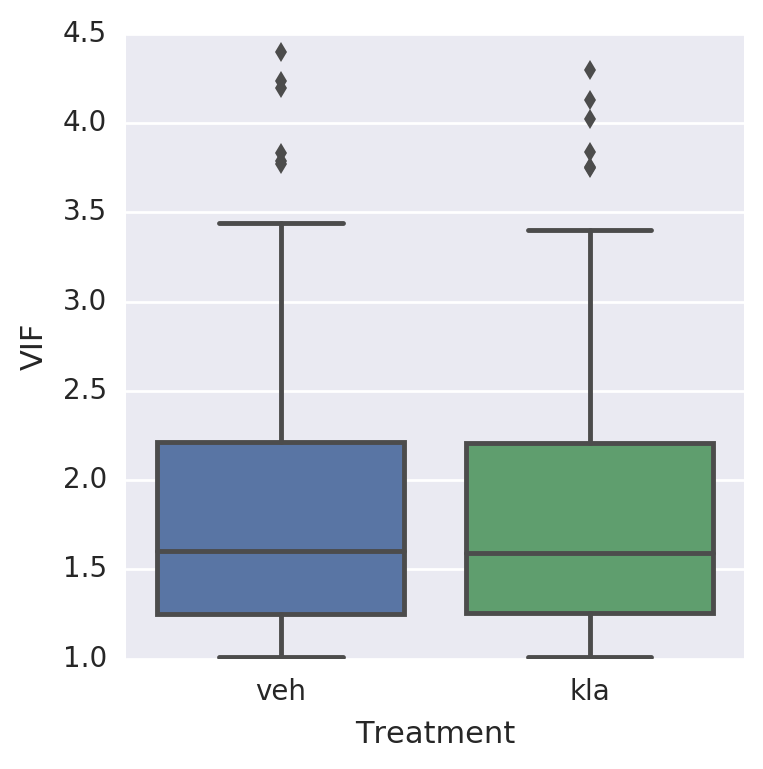

In [42]:
vif_frame = pd.DataFrame({'Motif Name': motif_names,
                          'Treatment': treatments,
                          'VIF':vifs})
sns.factorplot(data = vif_frame, 
               kind='box',
               x = 'Treatment',
               y = 'VIF')

## Robustness of Classifier

In [11]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  


In [12]:
# for monomers using all motifs
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_intercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_' + treatment)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_dict[monomer + '_' + treatment] = all_intercepts
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.84984989797 3.56800084125e-06 precision: 0.767598274006 7.23304775889e-06 numTestPositives: 12138
cjun_veh roc: 0.825121126962 6.93428358136e-06 precision: 0.602770999482 2.03933089027e-05 numTestPositives: 8736
fos_veh roc: 0.834451936473 4.48962873048e-06 precision: 0.294984245307 5.58617891742e-05 numTestPositives: 1991
junb_veh roc: 0.688796818103 9.03191591995e-05 precision: 0.0205305196151 2.75102833017e-06 numTestPositives: 254
jund_veh roc: 0.829323314834 2.26137886073e-06 precision: 0.736128200938 7.9890511048e-06 numTestPositives: 13552
atf3_kla roc: 0.857865921866 9.52703062257e-08 precision: 0.86551335797 8.9679781479e-07 numTestPositives: 20352
cjun_kla roc: 0.814627046618 3.54444429027e-07 precision: 0.585516070509 1.02373395378e-06 numTestPositives: 11047
fos_kla roc: 0.843350191161 3.72976050211e-06 precision: 0.769692914058 1.01912417628e-05 numTestPositives: 15729
junb_kla roc: 0.827944827165 2.9581010435e-06 precision: 0.655708629223 1.1002169074e-05 

In [13]:
coefficient_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

### Robustness of Intercept

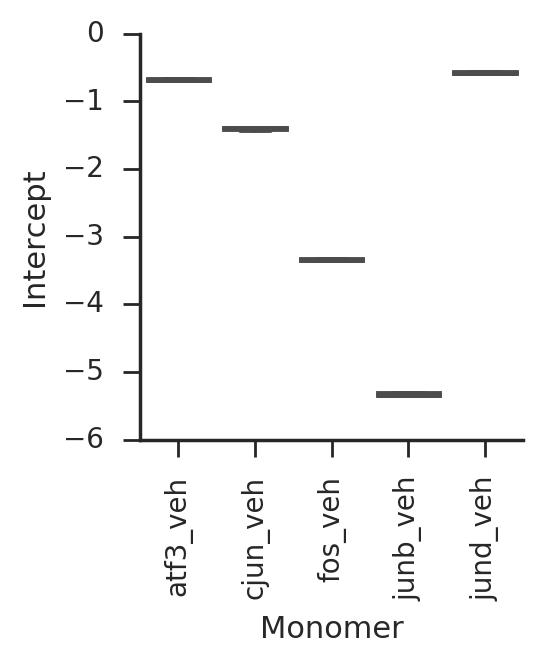

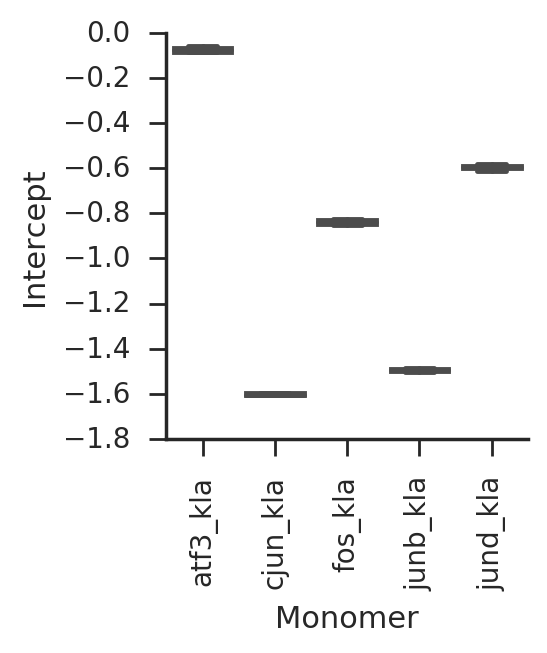

In [15]:
weight_threshold = 0.0
### box plots of coefficient variance ###
monomers = []
intercepts = []

for monomer in sorted(factor_intercept_dict.keys()):
    monomers = monomers + [monomer] *  numIterations
    
    all_intercepts = factor_intercept_dict[monomer]
    intercepts = intercepts + all_intercepts
    
data = pd.DataFrame({'Monomer':monomers,
                     'Intercept': intercepts
                     })

# consider only motifs with weight greater than weight_threshold for at least one monomer in one condition
selected_motifs = coefficients_standardized_frame[coefficients_standardized_frame.abs().max(axis=1) >= weight_threshold].index.values

for treatment in ['veh', 'kla']:
    with sns.axes_style('ticks'):
        
        sns.factorplot(data = data[data['Monomer'].str.contains(treatment)],
                       x = 'Monomer',
                       y= 'Intercept',
                       kind = 'box',
                       size=3, 
                       showfliers= False)
        plt.xticks(rotation=90)

        plt.show()



### Robustness of Coefficients

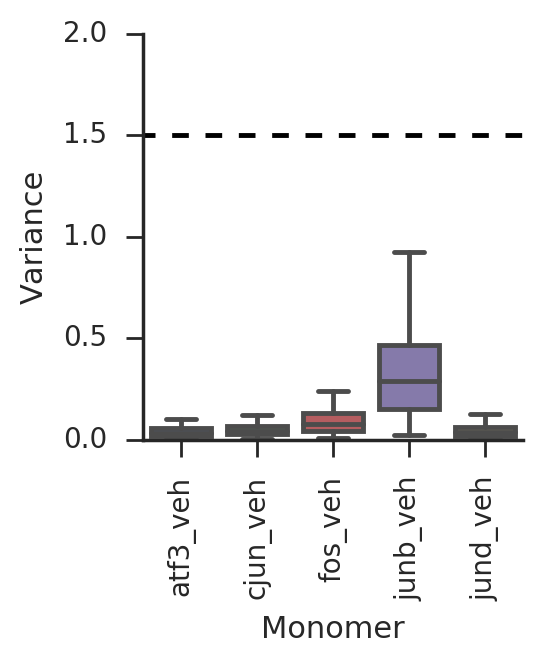

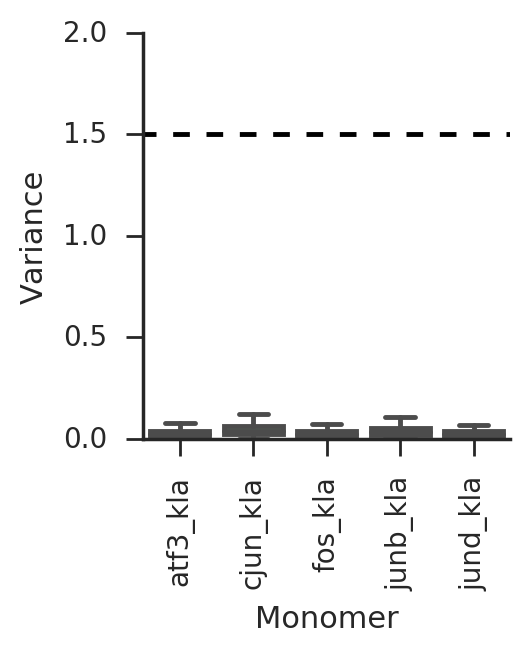

In [17]:
### box plots of coefficient variance ###
monomers = []
variances = []
motif_names = []
treatments = []
weight_threshold = 0.0
motifs = list(standardized_motif_frame.columns.values)
for monomer in sorted(factor_coeff_dict.keys()):
    monomers = monomers + ([monomer] *  len(motifs))  
    
    motif_names  = motif_names + motifs
    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients).T
    
    scaler = sklearn.preprocessing.StandardScaler()
    current_coeff_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame))
    current_var = current_coeff_frame_std.var(axis=1)

    variances = variances + list(current_var)

data = pd.DataFrame({'Monomer':monomers,
                     'Variance':variances,
                     'Motif Name': motif_names
                     })

# consider only motifs with weight greater than weight_threshold for at least one monomer in one condition
selected_motifs = coefficients_standardized_frame[coefficients_standardized_frame.abs().max(axis=1) >= weight_threshold].index.values

for treatment in ['veh', 'kla']:
    with sns.axes_style('ticks'):
        
        sns.factorplot(data = data[(data['Monomer'].str.contains(treatment)) &
                                   (data['Motif Name'].isin(selected_motifs))],
                       x = 'Monomer',
                       y= 'Variance',
                       kind = 'box',
                       size=3, 
                       showfliers= False)
        plt.xticks(rotation=90)
        plt.hlines(xmin = -1, xmax = 5, y=1.5, linestyles='--')
        plt.ylim(0,2)
        plt.show()


In [ ]:
### mean motif vs variance scatter plots for each monomer ###
for monomer in sorted(factor_coeff_dict.keys()):

    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients)
    scaler = sklearn.preprocessing.StandardScaler()
    all_coefficients_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame.T))
    current_var = all_coefficients_frame_std.var(axis=1)
    current_mean = all_coefficients_frame_std.mean(axis=1)
    with sns.axes_style('ticks'):
        plt.scatter(current_mean, current_var, marker = '.')
        plt.title(monomer)
        plt.ylabel('Variance')
        plt.xlabel('Motif Weight')
        sns.despine()
        
        plt.show()



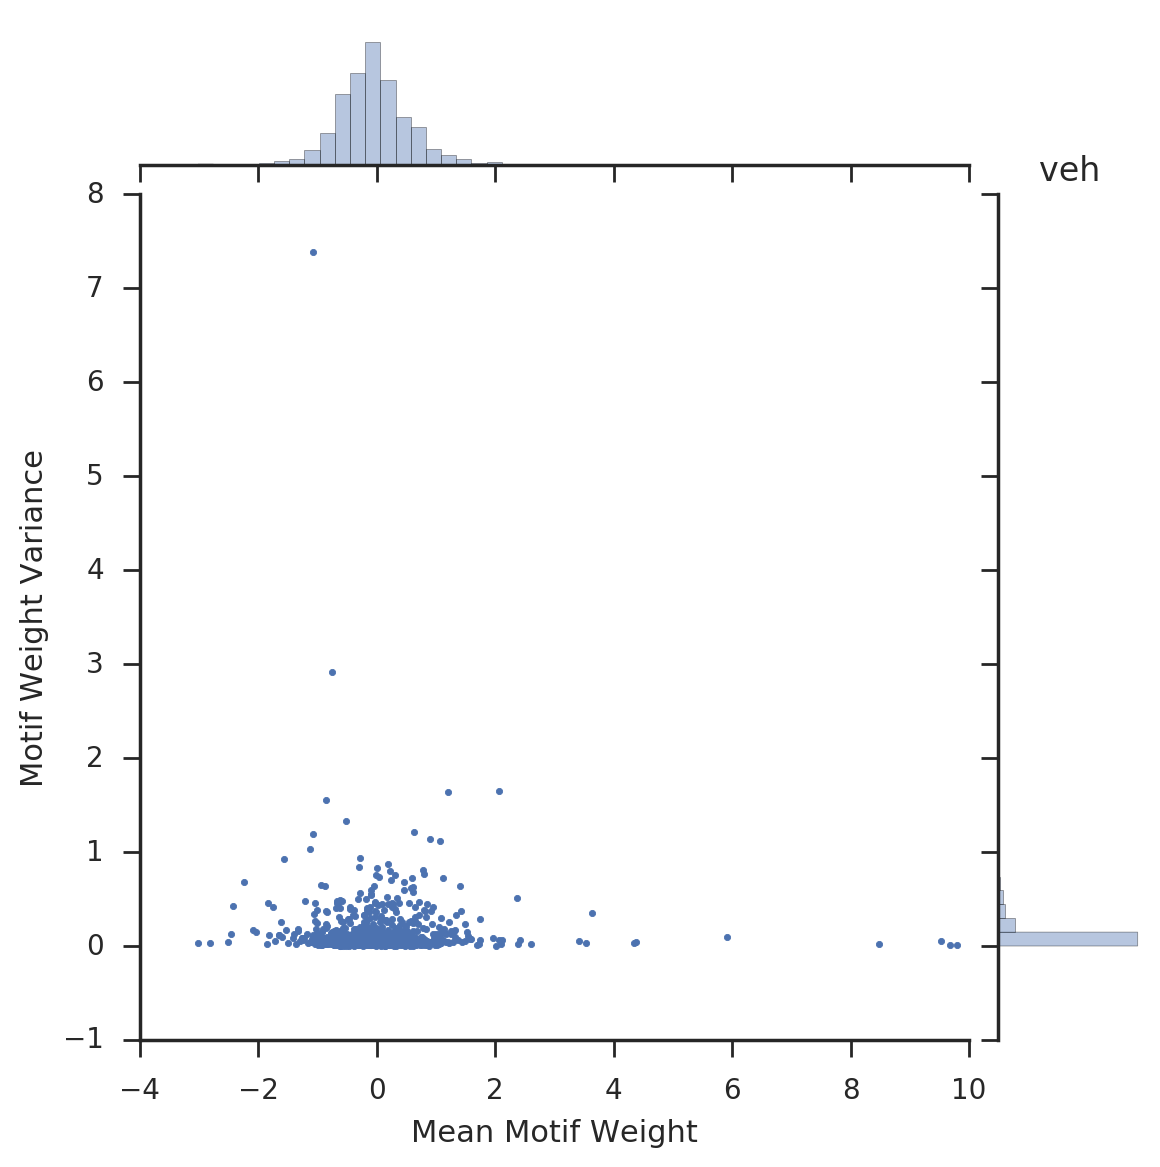

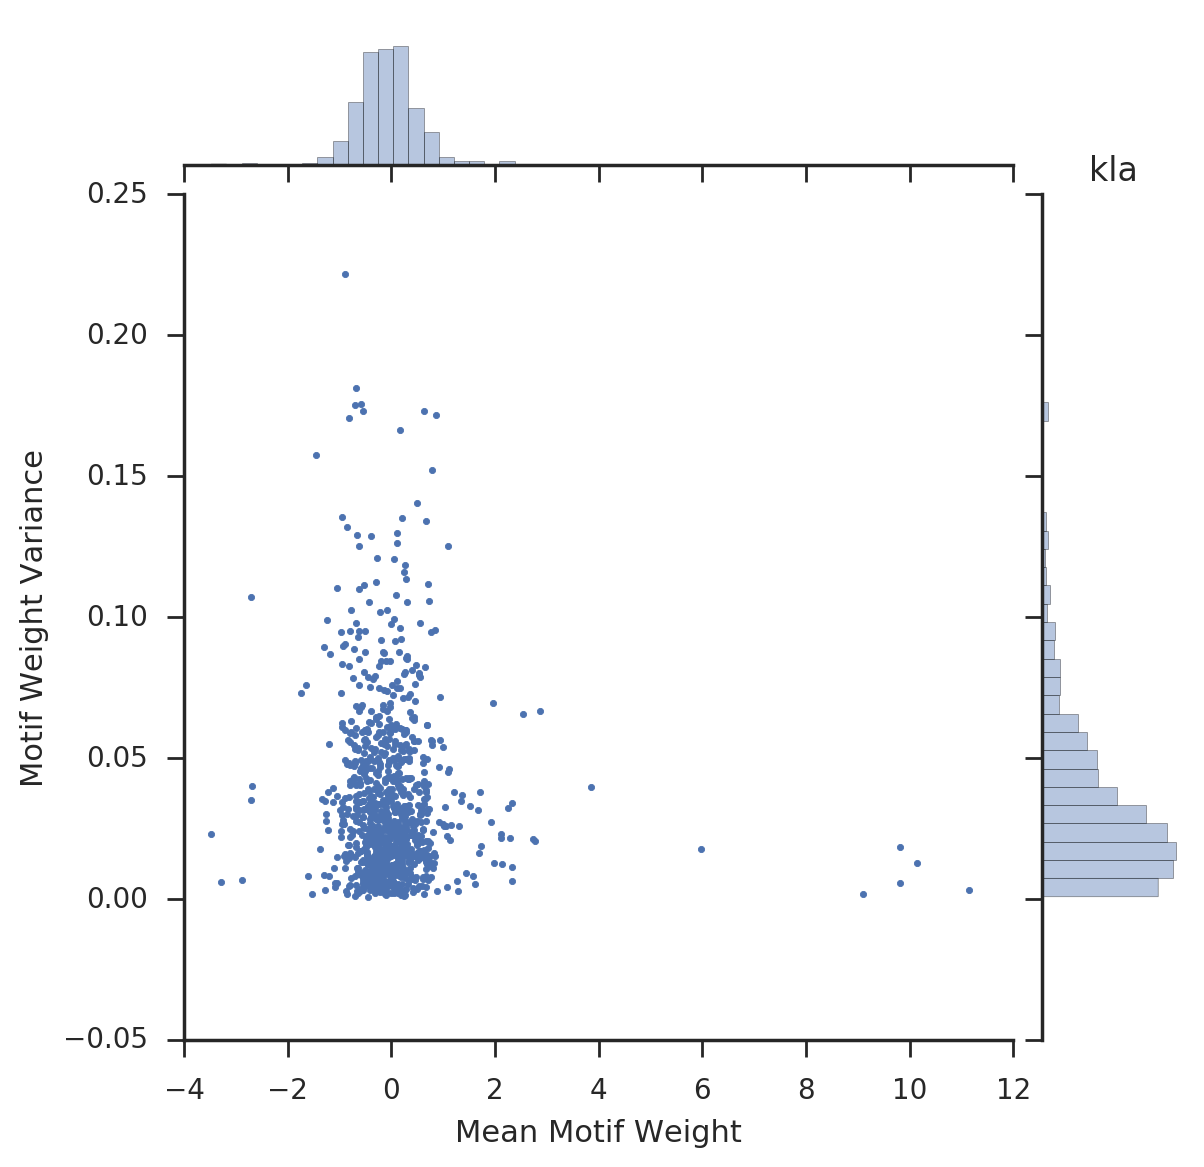

In [19]:
### scatter plots of coefficient variance ###
monomers = []
variances = []
motif_names = []
treatments = []
means = []
for monomer in sorted(factor_coeff_dict.keys()):
    monomers = monomers + ([monomer] *  len(motifs))  
    
    motif_names  = motif_names + motifs
    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients).T
    scaler = sklearn.preprocessing.StandardScaler()
    current_coeff_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame))
    current_var = current_coeff_frame_std.var(axis=1)
    current_means = current_coeff_frame_std.mean(axis=1)
    variances = variances + list(current_var)
    means = means + list(current_means)

data = pd.DataFrame({'Monomer':monomers,
                     'Motif Weight Variance':variances,
                     'Motif Name': motif_names,
                     'Mean Motif Weight':means
                     })
for treatment in ['veh', 'kla']:
    with sns.axes_style('ticks'):
        sns.jointplot(data = data[data['Monomer'].str.contains(treatment)],
                       x = 'Mean Motif Weight',
                       y= 'Motif Weight Variance',
                       kind = 'scatter',
                      stat_func = None,
                      marker='.'
                       )
        plt.xticks(rotation=90)
        plt.title(treatment)
        plt.show()



## Performance of Averaged Coefficients

In [9]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  


### run individual classifiers

In [10]:
# for monomers using all motifs
strain = 'c57bl6'
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_intercept_dict = {}
factor_meanIntercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.837910009744 1.20209774133e-06 precision: 0.715956765487 6.04532884851e-06 numTestPositives: 11063
cjun_veh roc: 0.810908742609 1.59943033035e-06 precision: 0.471296605026 8.68595290987e-06 numTestPositives: 6369
fos_veh roc: 0.862357102819 4.82301920342e-06 precision: 0.362580229095 7.24740499519e-05 numTestPositives: 985
junb_veh roc: 0.677741215682 2.73206311734e-05 precision: 0.0196560185476 1.99284756789e-06 numTestPositives: 243
jund_veh roc: 0.807817170399 1.89703847262e-06 precision: 0.564949364861 5.1872091708e-06 numTestPositives: 9053
atf3_kla roc: 0.833134319703 1.08367457148e-06 precision: 0.804648016923 5.73749905593e-06 numTestPositives: 17315
cjun_kla roc: 0.806851845494 1.68224089315e-06 precision: 0.482229949173 5.93896760776e-06 numTestPositives: 8041
fos_kla roc: 0.831502180546 1.1794656152e-06 precision: 0.65942651865 4.47043168458e-06 numTestPositives: 10795
junb_kla roc: 0.828387240705 2.88363916358e-06 precision: 0.481605295576 5.61141543578e-06 

### measure performance of averaged classifier

In [11]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

In [12]:
coefficient_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

In [13]:
factor_auc_dict_avg = {}
factor_precision_dict_avg = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)
                
                weights = factor_meanCoeff_dict[monomer + '_' + treatment]
                intercept = factor_meanIntercept_dict[monomer + '_' + treatment]
                scores = np.dot(test_features, weights) + intercept
                probs = np.array([signmoid(x) for x in scores])
                
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probs, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probs, average = None)
    
                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)
            
            
            factor_auc_dict_avg[monomer + '_' + treatment] = all_aucs
            factor_precision_dict_avg[monomer + '_' + treatment] = all_precisions

                
            print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

atf3 veh
atf3_veh roc: 0.840824759053 8.22245855499e-06 precision: 0.718389684435 4.37611480353e-05 numTestPositives: 11101
cjun veh
cjun_veh roc: 0.816659281114 1.06866626201e-06 precision: 0.479249781209 1.00260449707e-05 numTestPositives: 6294
fos veh
fos_veh roc: 0.878144888689 5.64400101992e-06 precision: 0.396067903207 0.000206904935992 numTestPositives: 1016
junb veh
junb_veh roc: 0.792127250261 2.08231537693e-05 precision: 0.0416224375923 6.74295599433e-06 numTestPositives: 246
jund veh
jund_veh roc: 0.811672564394 1.33552874839e-06 precision: 0.571691954576 2.27421080862e-05 numTestPositives: 9101
atf3 kla
atf3_kla roc: 0.834020025653 1.46334554827e-06 precision: 0.806514491053 3.92541414764e-06 numTestPositives: 17453
cjun kla
cjun_kla roc: 0.810814617686 1.95232626821e-06 precision: 0.488393630431 1.13940652944e-05 numTestPositives: 8092
fos kla
fos_kla roc: 0.834655684382 3.5307254905e-07 precision: 0.665839387985 1.87355358457e-06 numTestPositives: 10644
junb kla
junb_kla 

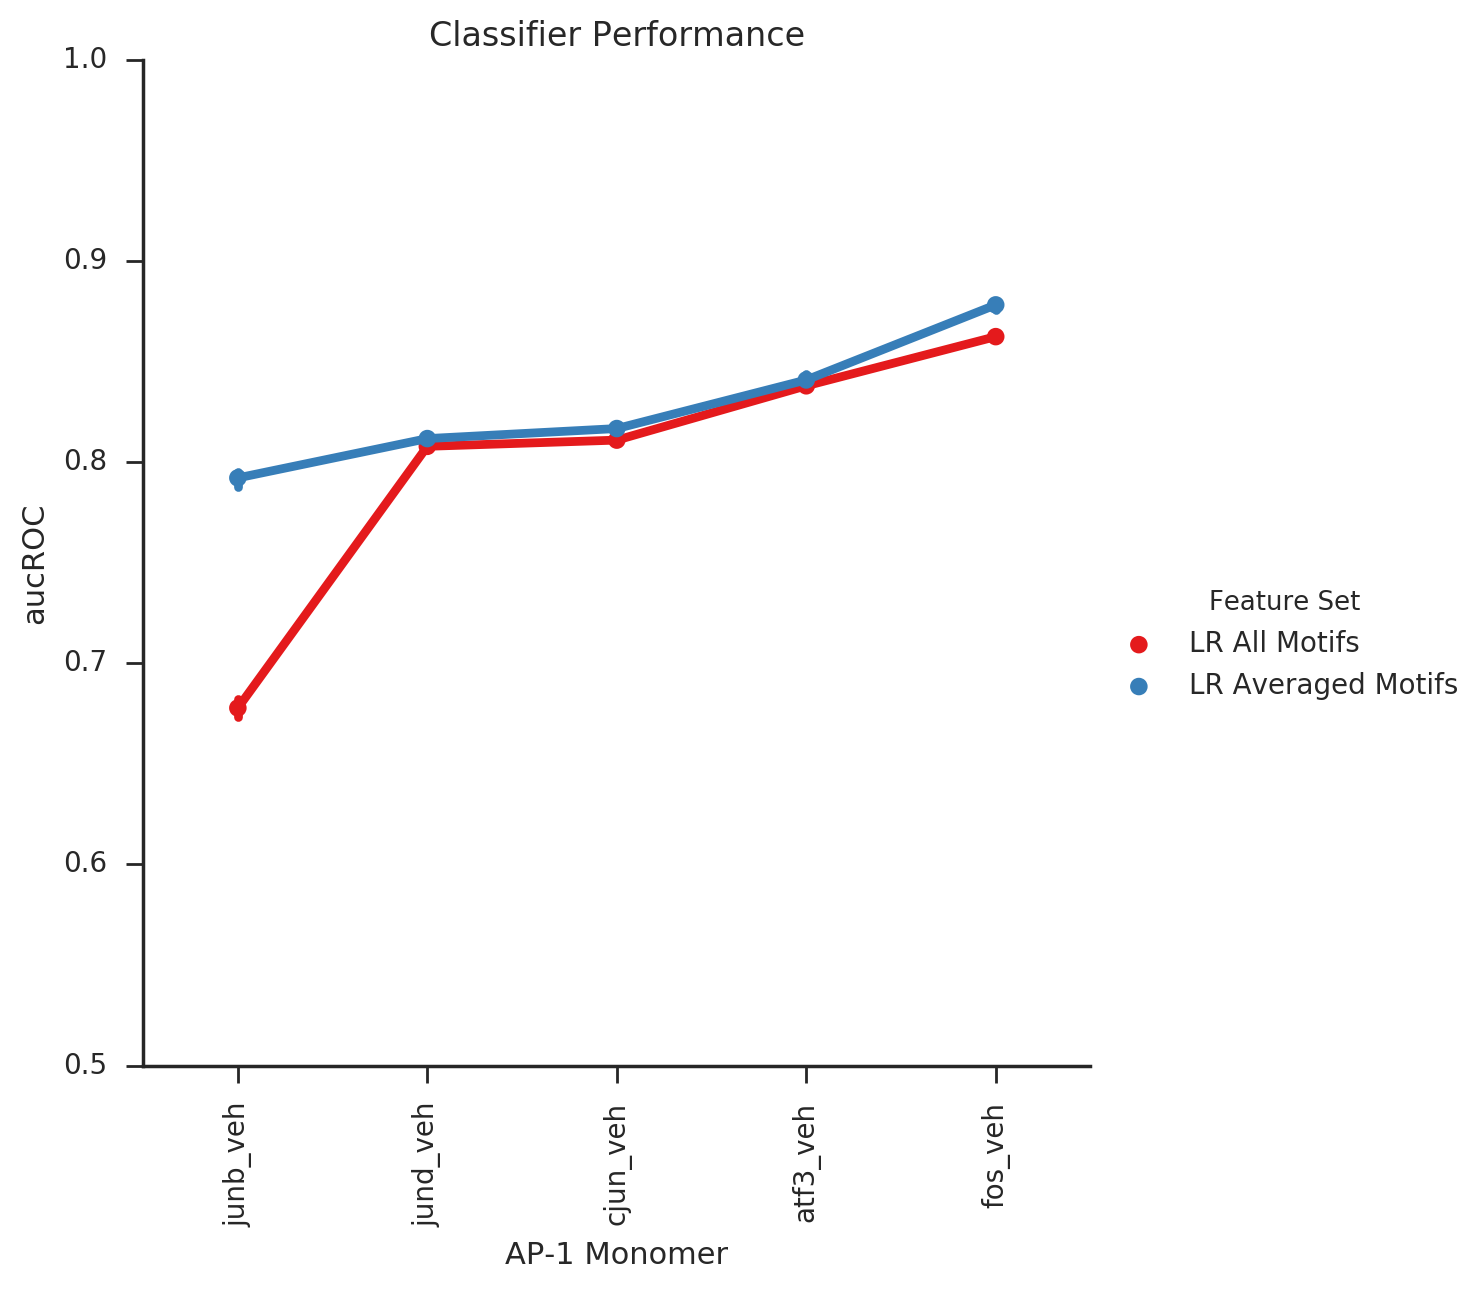

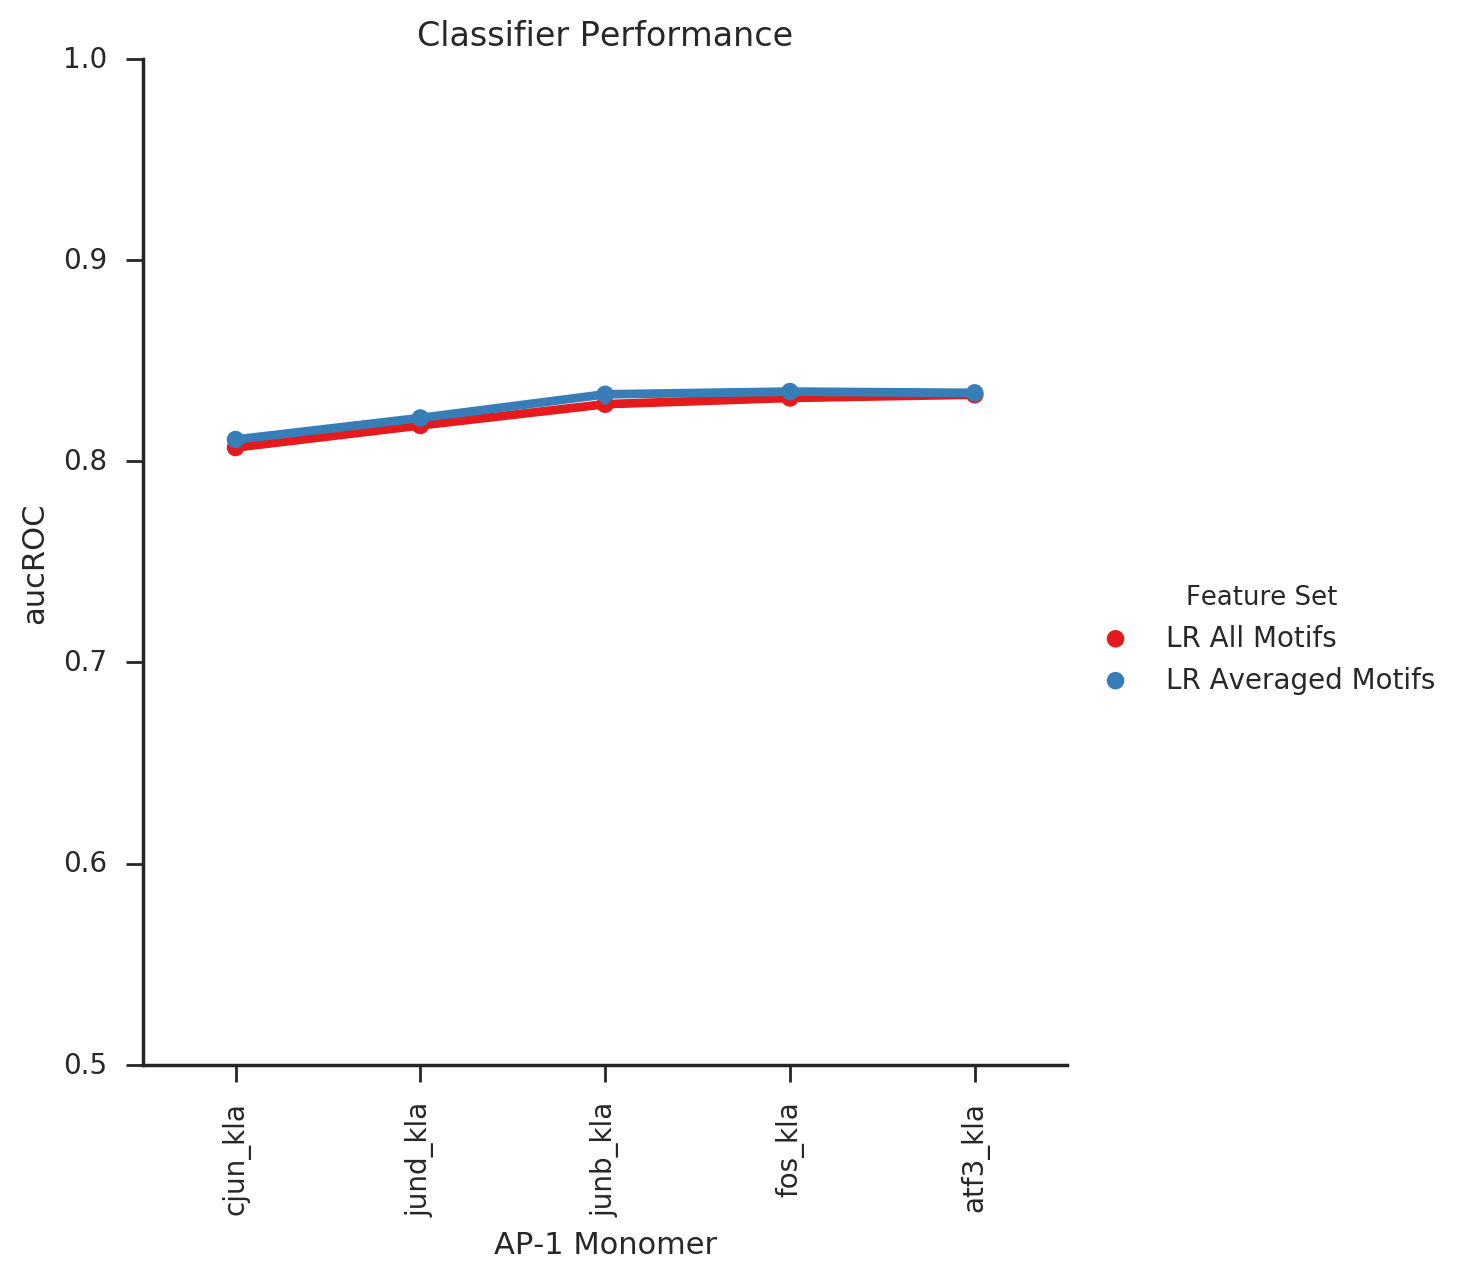

In [14]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_dict.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_avg[factor]
    feature_set = feature_set + numIterations * ['LR Averaged Motifs']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict[x])) for x in factor_auc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()

## Plot Classifier Probabilities Vs Peak Scores

atf3 veh
0.50507466596 (63973, 196) 63973


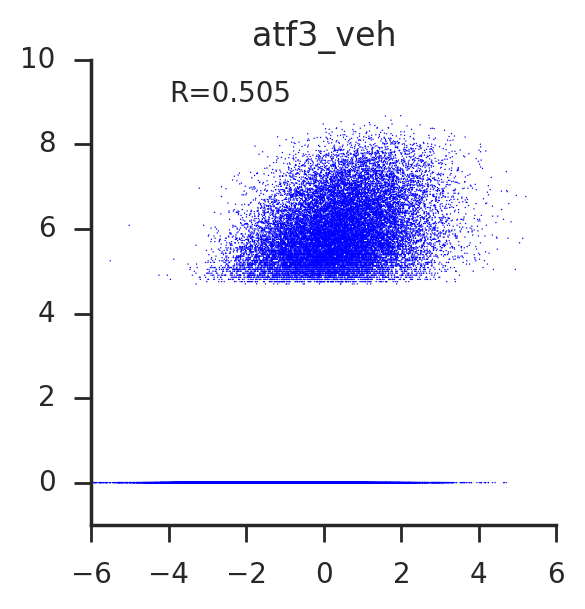

cjun veh
0.429496990809 (63973, 196) 63973


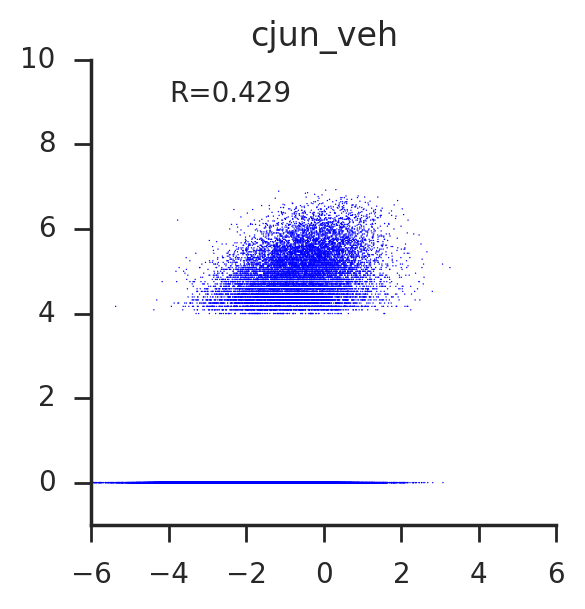

fos veh
0.265328274447 (63973, 196) 63973


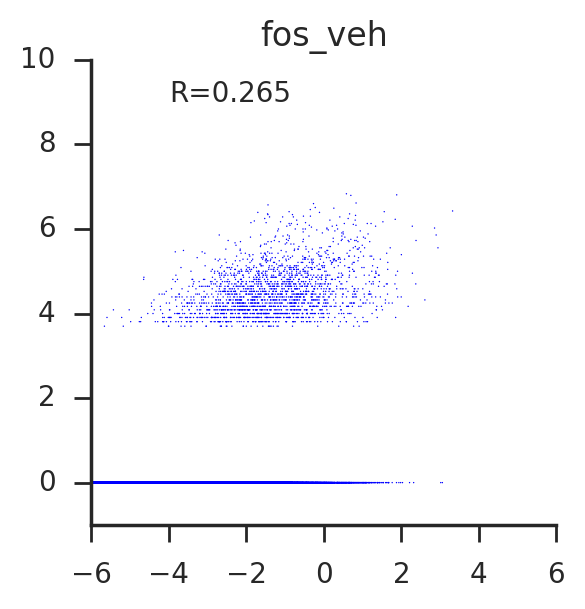

junb veh
0.0897687282054 (63973, 196) 63973


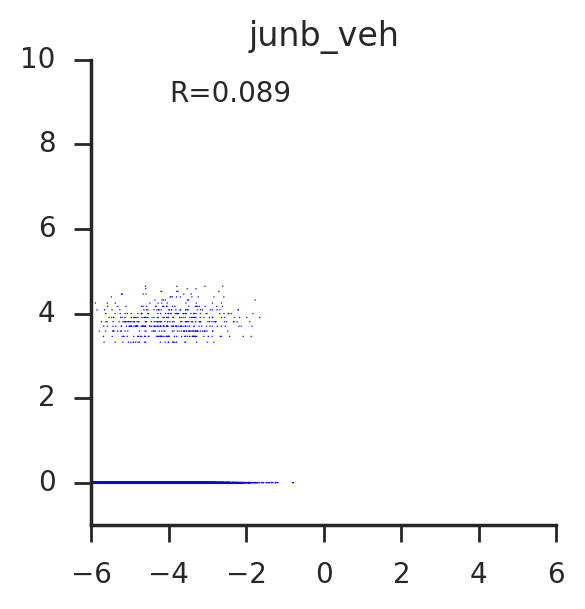

jund veh
0.471913750656 (63973, 196) 63973


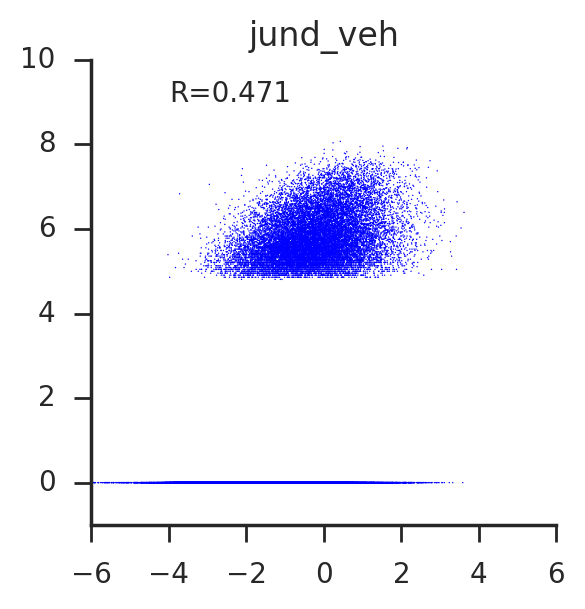

atf3 kla
0.534279566312 (80046, 196) 80046


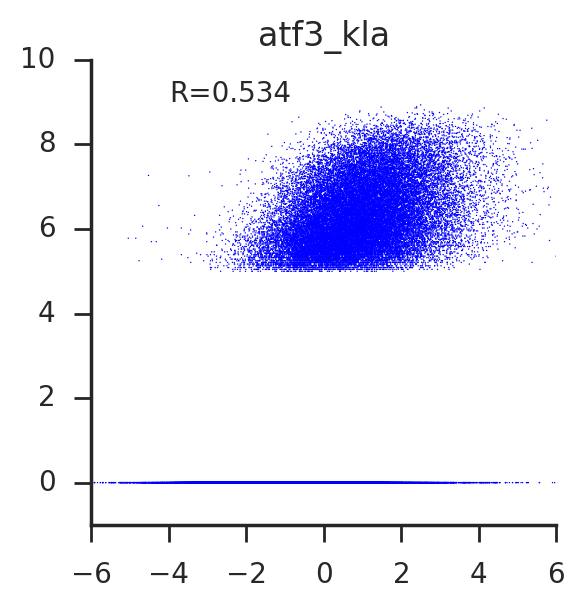

cjun kla
0.414417669113 (80046, 196) 80046


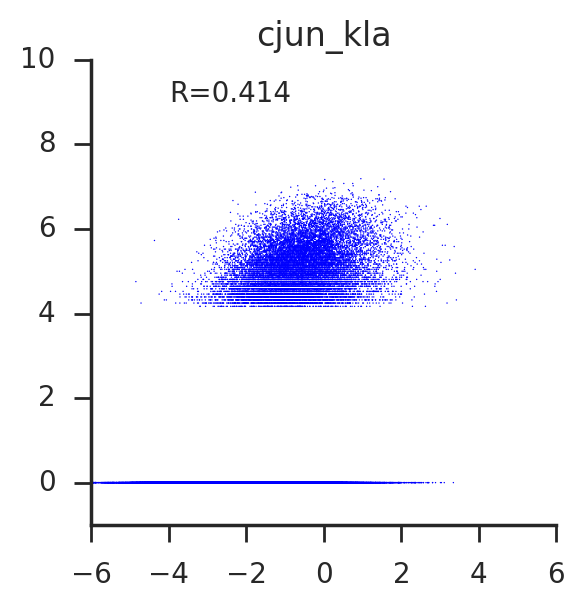

fos kla
0.492041639127 (80046, 196) 80046


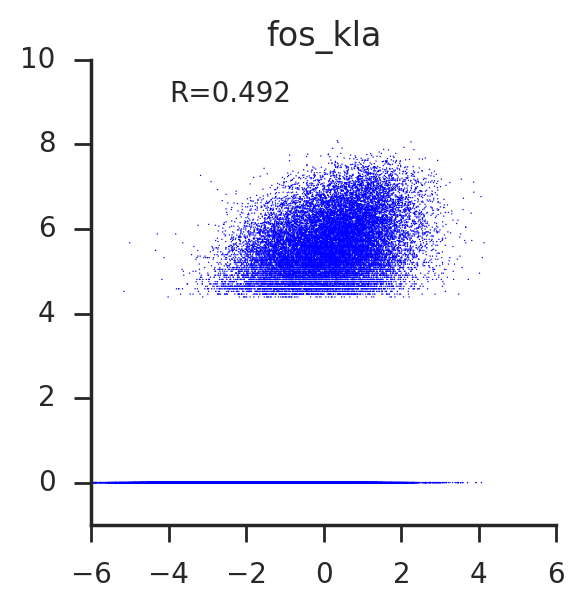

junb kla
0.407974474843 (80046, 196) 80046


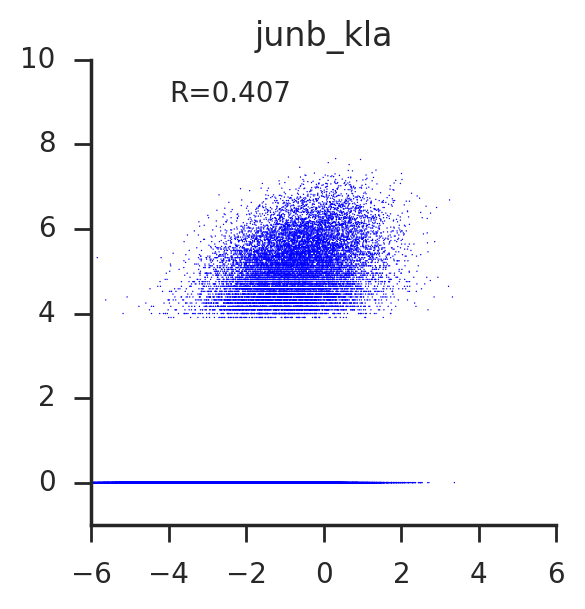

jund kla
0.520775710633 (80046, 196) 80046


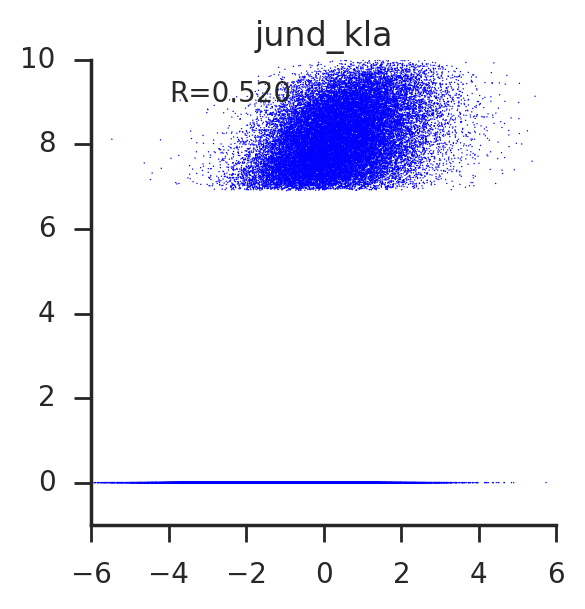

In [34]:
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        c57bl6_indices = summary_frame[summary_frame[[strain + '_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:

            # calculate probabilities using averaged weights
            weights = factor_meanCoeff_dict[monomer + '_' + treatment]
            intercept = factor_meanIntercept_dict[monomer + '_' + treatment]
            scores = np.dot(features, weights) + intercept
            probs = np.array([signmoid(x) for x in scores])

            # get real binding scores
            binding_scores = summary_frame[summary_frame.index.isin(labels.index.values)][strain + '_' + monomer + '_' + treatment]
            pearson, pval = scipy.stats.pearsonr(scores, binding_scores)
            print(pearson, features.shape, len(binding_scores))
            with sns.axes_style('ticks'):
                fig = plt.figure(figsize=(3,3))
                plt.scatter(scores, np.log2(binding_scores + 1), 
                            marker = '.',
                            edgecolor='None',
                            s=1)
                plt.annotate('R='+str(pearson)[:5], xy = (-4,9), size=10)
                sns.despine()
                plt.xlim(-6,6)
                plt.ylim(-1,10)
                plt.title(monomer + '_' + treatment)
                ax = plt.gca()
                x0,x1 = ax.get_xlim()
                y0,y1 = ax.get_ylim()
                ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                plt.show()

atf3 veh
cjun veh
fos veh
junb veh
jund veh
atf3 kla
cjun kla
fos kla
junb kla
jund kla


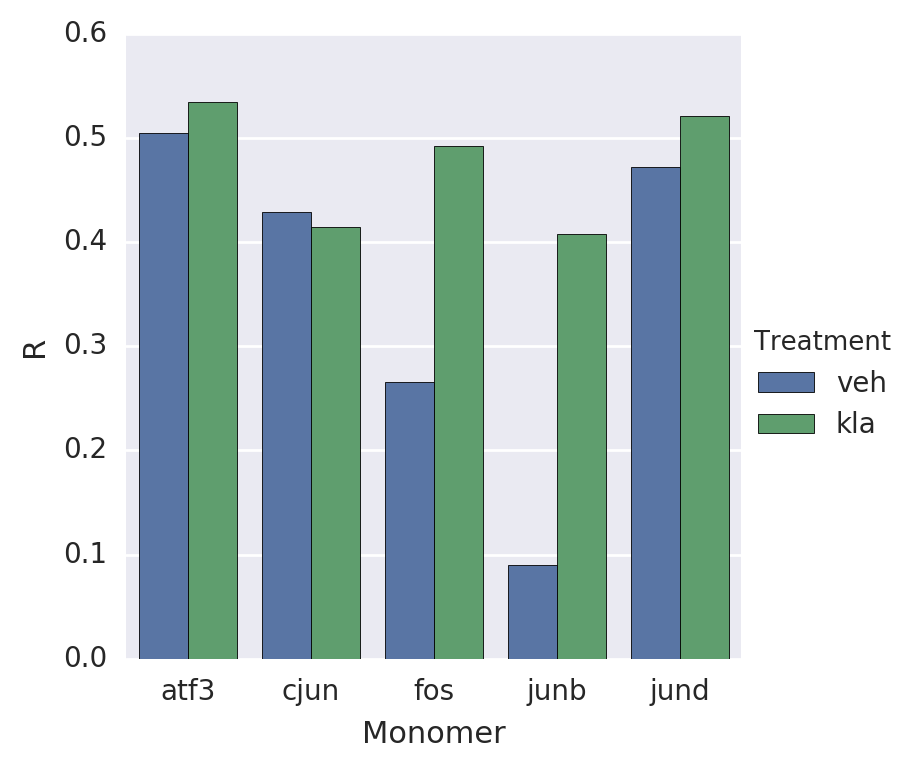

In [38]:
strain = 'c57bl6'
factor_list = []
treatment_list = []
pearson_list = []
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        c57bl6_indices = summary_frame[summary_frame[[strain + '_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:

            # calculate probabilities using averaged weights
            weights = factor_meanCoeff_dict[monomer + '_' + treatment]
            intercept = factor_meanIntercept_dict[monomer + '_' + treatment]
            scores = np.dot(features, weights) + intercept
            probs = np.array([signmoid(x) for x in scores])

            # get real binding scores
            binding_scores = summary_frame[summary_frame.index.isin(labels.index.values)][strain + '_' + monomer + '_' + treatment]
            pearson, pval = scipy.stats.pearsonr(scores, binding_scores)
            
            factor_list.append(monomer)
            treatment_list.append(treatment)
            pearson_list.append(pearson)
sns.factorplot(data=pd.DataFrame({'Monomer': factor_list,
                            'Treatment': treatment_list,
                            'R': pearson_list}),
               kind='bar',
               x = 'Monomer',
               y= 'R',
               hue = 'Treatment')